# Analysis of dynamic network ABM
Standard networks, no SDA yet

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import itertools

/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_17164/2894705791.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from assortativity_model_copy import ConsumatModel

In [3]:
base_config = {
    'TP_percentage': 0.6,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 10.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'budget'  # Attribute to use for homophily-based rewiring
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.3
    }
})


### Functions that can run for various config

In [4]:

def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    all_simulation_data = {}
    
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} with parameters: {config}")
        
        all_simulation_data[config_name] = []
        
        for simulation in range(num_simulations):
            model = ConsumatModel(config)
            model_data, agent_data = run_simulation(model, num_steps)
            all_simulation_data[config_name].append(model_data)

        aggregated_data = pd.concat(all_simulation_data[config_name]).groupby(level=0).mean()
        results[config_name] = aggregated_data

    return results, all_simulation_data


def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count





In [5]:


def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]
    
    # Group configurations by network
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    # Plot each network's configurations
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(12, 8))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], label=f'{param_name} - Simulation {idx + 1}', alpha=0.7)
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust legend to be outside the plot
       




def plot_network_metrics(results, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in results.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 5))
        
        metrics_plotted = False
        for config_name in config_names:
            aggregated_data = results[config_name]
            tp_value = config_name.split('_TP_')[1]
            if 'Average Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Degree'], marker='o', label=f'Average Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Variance of Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Variance of Degree'], marker='o', label=f'Variance of Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Clustering' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Clustering'], marker='o', label=f'Average Clustering {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Path Length' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Path Length'], marker='o', label=f'Average Path Length {param_name} {tp_value}', linestyle='--')
                metrics_plotted = True
        
        if metrics_plotted:
            plt.xlabel('Step')
            plt.ylabel('Metric Value')
            plt.title(f'Network Metrics Over Time for {network_name}')
            plt.legend()
            plt.show()


def plot_decision_modes(network_configurations, num_steps):
    for network_name, config in network_configurations.items():
        model = ConsumatModel(config)
        _, agent_data = run_simulation(model, num_steps)
        
        decision_modes_count = generate_decision_modes_count(agent_data)
        print(f"Decision Mode Counts for {network_name} network:")
        print(decision_modes_count)

        plt.figure(figsize=(12, 8))
        plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
        plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
        plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
        plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
        plt.title(f'Decision Modes over Time for {network_name} network')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

In [6]:
# Example usage
varying_params = {'TP_percentage': [0.6]}  # Update this with your actual varying parameters
results, all_simulation_data = run_all_simulations(
    {'watts_strogatz': watts_strogatz_config, 'barabasi_albert': barabasi_albert_config, 'random_regular': random_regular_config, 'holme_kim': holme_kim_config},
    num_steps=8,  # Update with your actual number of steps
    num_simulations=10  # Update with your actual number of simulations
)


Running simulations for watts_strogatz with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.3}}


Simulation Progress: 100%|██████████| 8/8 [00:00<00:00,  9.04it/s]


Running simulations for barabasi_albert with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


Running simulations for random_regular with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s]


Running simulations for holme_kim with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'budget', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.3}}


Simulation Progress: 100%|██████████| 8/8 [00:01<00:00,  4.29it/s]


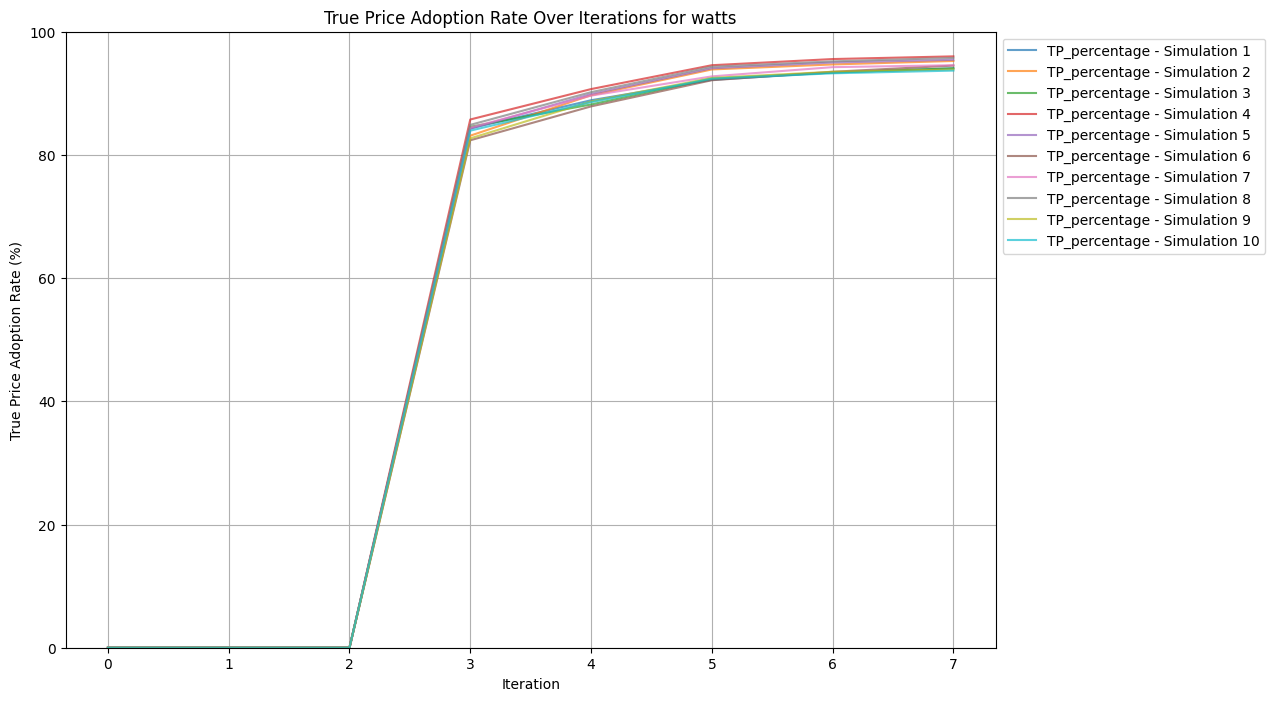

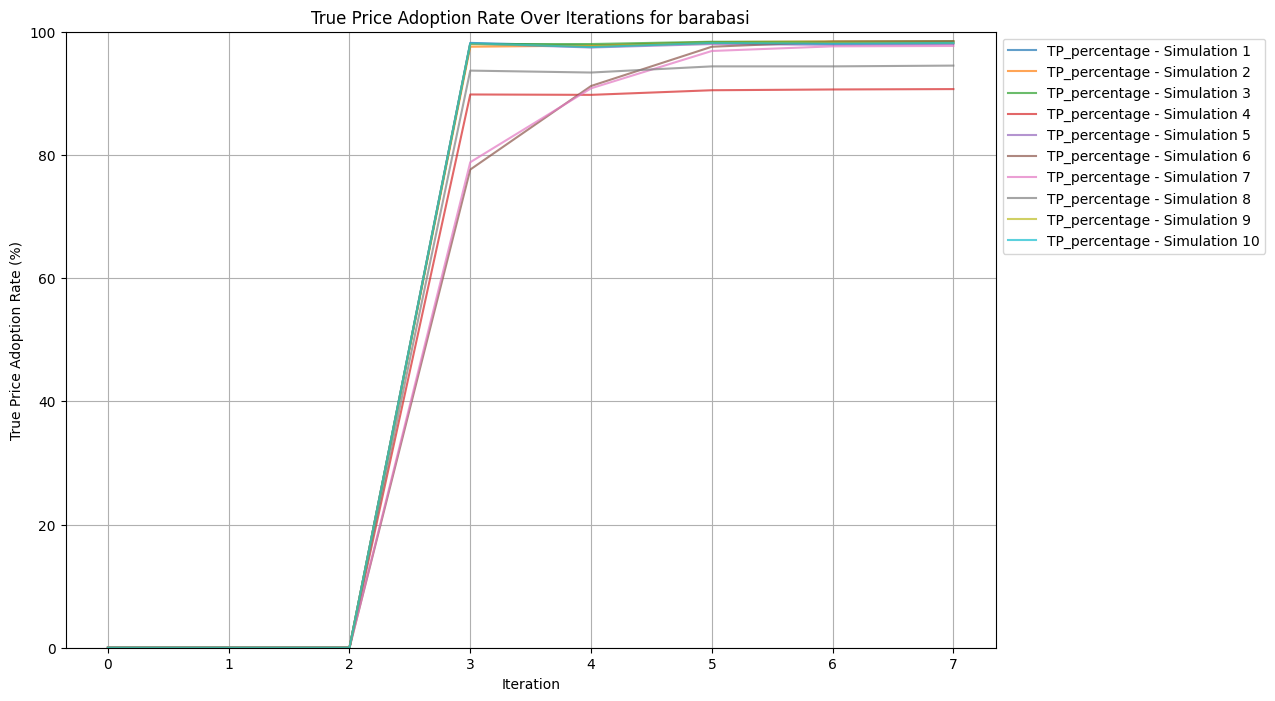

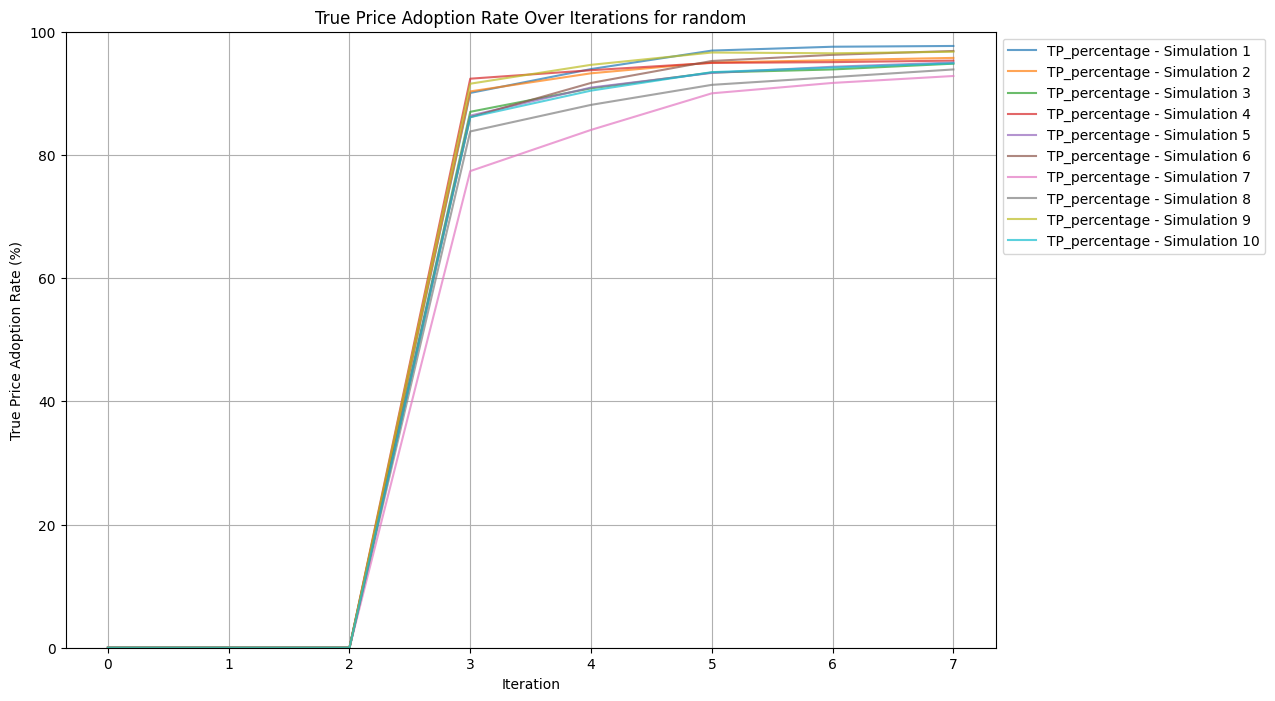

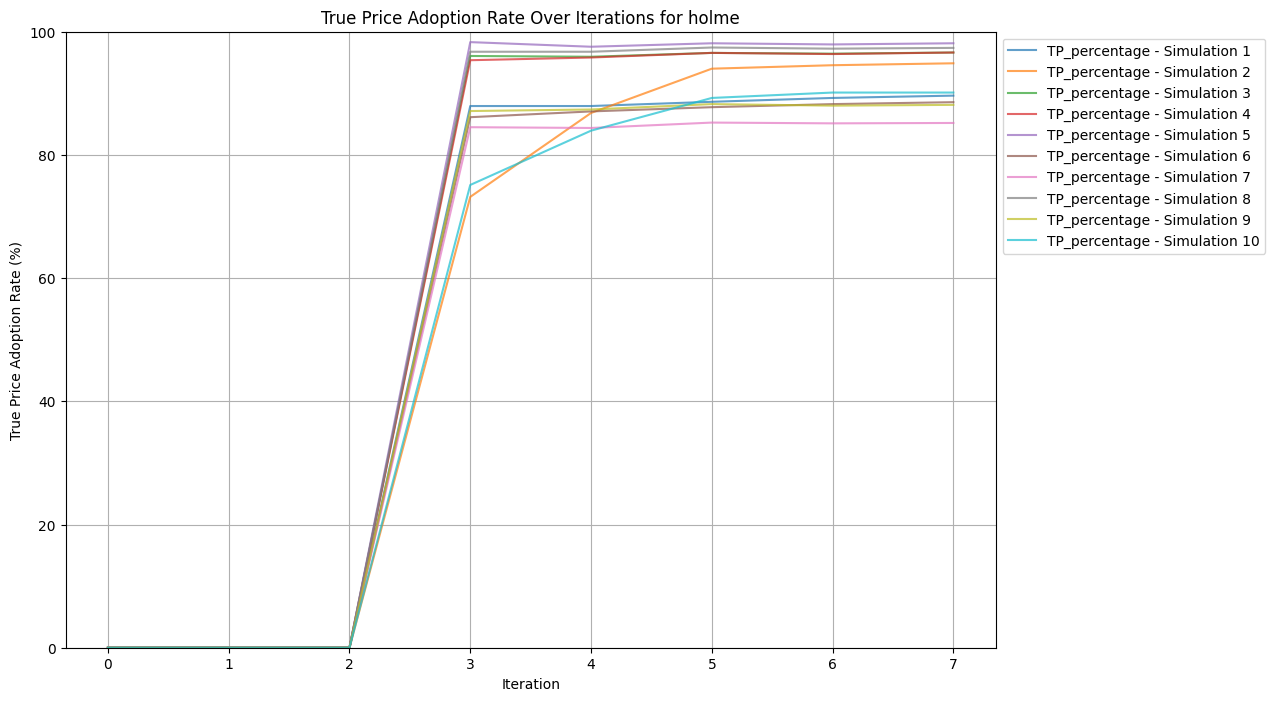

In [7]:
plot_adoption_rates(all_simulation_data, varying_params)


### Plotting functions for various config

### Create configs based on varying parameters

In [6]:

def generate_configurations(base_config, varying_params):
    keys, values = zip(*varying_params.items())
    configurations = []
    
    for combination in itertools.product(*values):
        config = base_config.copy()
        config.update(dict(zip(keys, combination)))
        configurations.append(config)
    
    return configurations


### Varying TP_percentage

Running simulations for Watts-Strogatz_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Running simulations for Watts-Strogatz_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Running simulations for Watts-Strogatz_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Running simulations for Watts-Strogatz_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Running simulations for Watts-Strogatz_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Running simulations for Watts-Strogatz_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Running simulations for Watts-Strogatz_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Running simulations for Watts-Strogatz_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Running simulations for Watts-Strogatz_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Running simulations for Watts-Strogatz_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Running simulations for Barabasi-Albert_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Running simulations for Barabasi-Albert_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Running simulations for Barabasi-Albert_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Running simulations for Barabasi-Albert_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Running simulations for Barabasi-Albert_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Running simulations for Barabasi-Albert_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Running simulations for Barabasi-Albert_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Running simulations for Barabasi-Albert_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Running simulations for Barabasi-Albert_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Running simulations for Barabasi-Albert_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Random Regular_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Running simulations for Random Regular_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Running simulations for Random Regular_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Running simulations for Random Regular_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Running simulations for Random Regular_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Running simulations for Random Regular_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Running simulations for Random Regular_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Running simulations for Random Regular_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Running simulations for Random Regular_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Running simulations for Random Regular_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Running simulations for Holme-Kim_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Running simulations for Holme-Kim_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Running simulations for Holme-Kim_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Running simulations for Holme-Kim_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Running simulations for Holme-Kim_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Running simulations for Holme-Kim_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Running simulations for Holme-Kim_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Running simulations for Holme-Kim_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Running simulations for Holme-Kim_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Running simulations for Holme-Kim_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


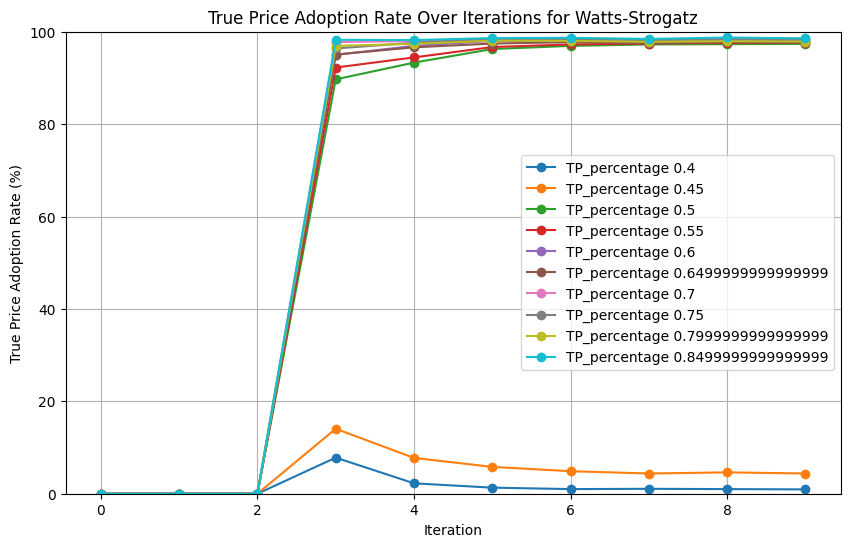

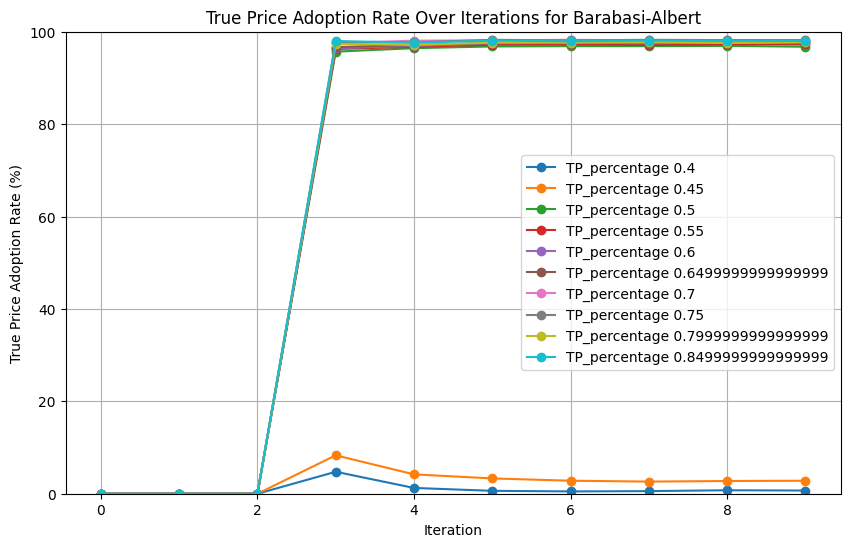

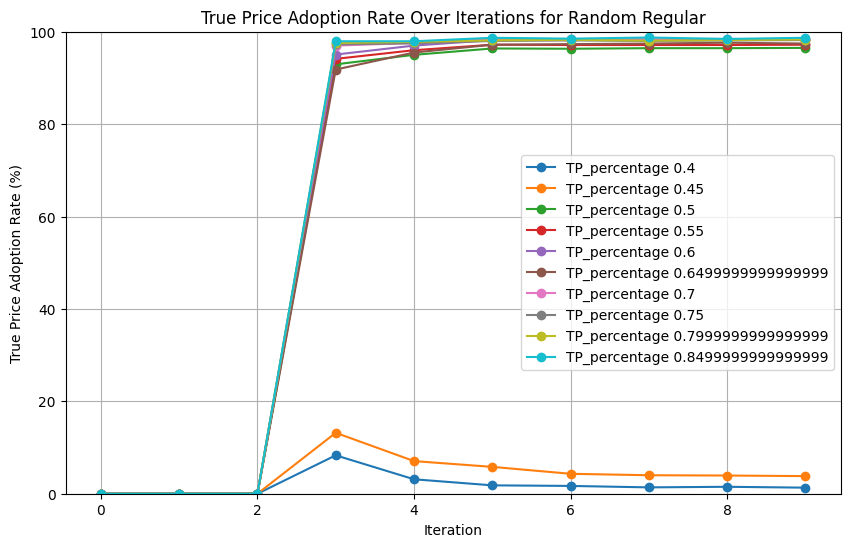

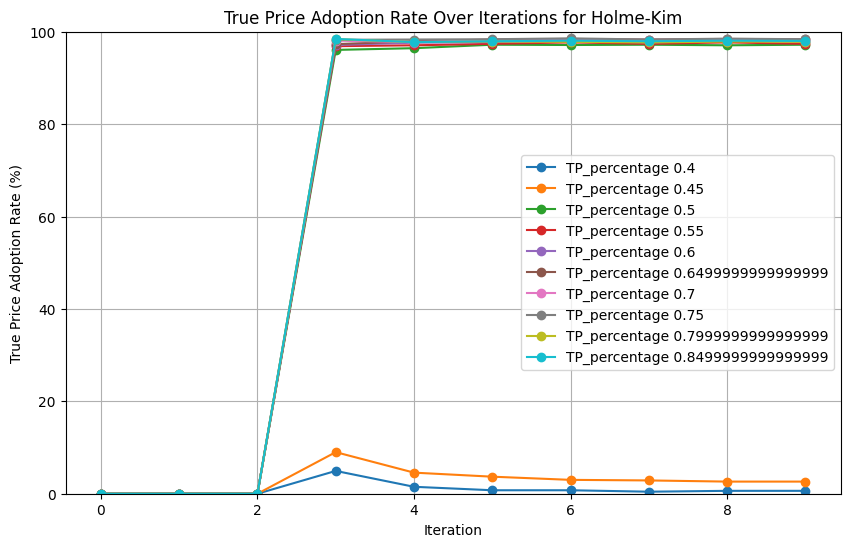

In [7]:
# Example network configurations (replace with actual configurations)
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Varying parameters
varying_params = {
    'TP_percentage': np.arange(0.4, 0.9, 0.05).tolist(),
}

num_simulations = 1
num_steps = 10

# Generate configurations
all_configurations = {}
for network_name, net_config in network_configurations.items():
    net_configs = generate_configurations({**base_config, **net_config}, varying_params)
    for idx, config in enumerate(net_configs):
        config_name = f"{network_name}_Config_{idx+1}_TP_{config['TP_percentage']}"
        all_configurations[config_name] = config

# Run all simulations
results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

# Plotting results
plot_adoption_rates(all_simulation_data, varying_params)



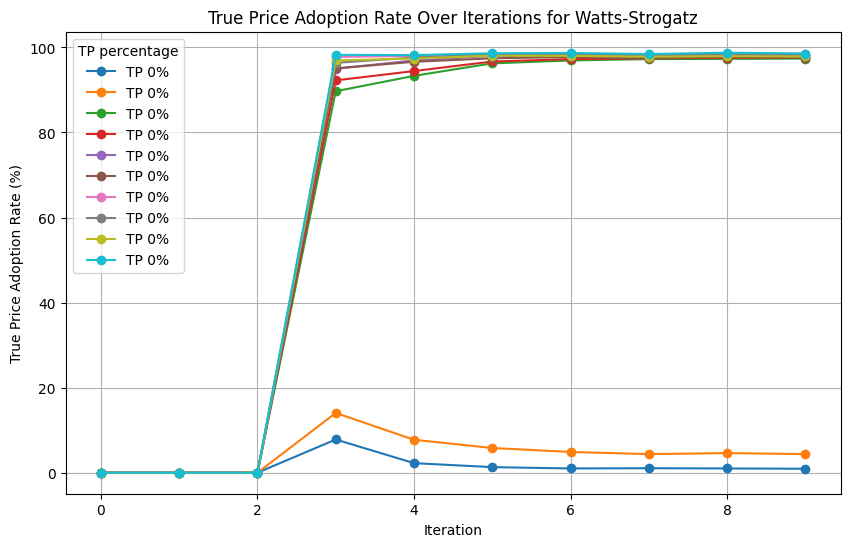

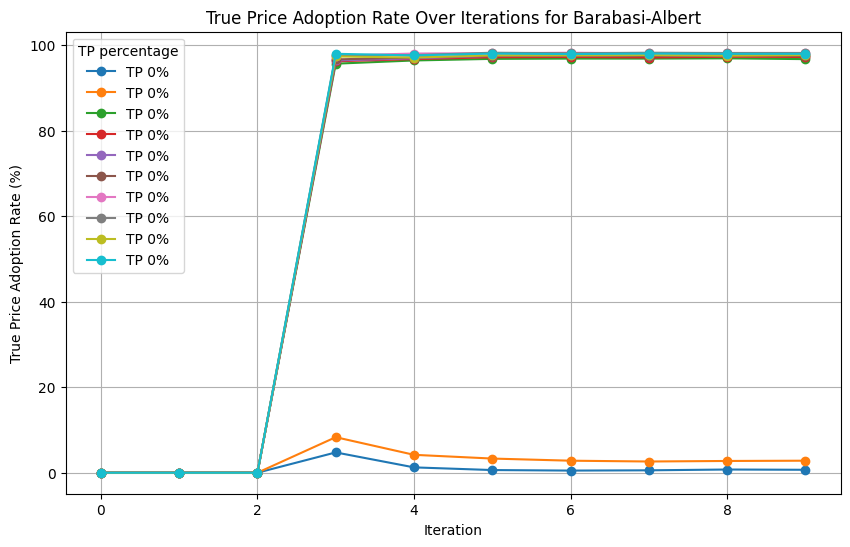

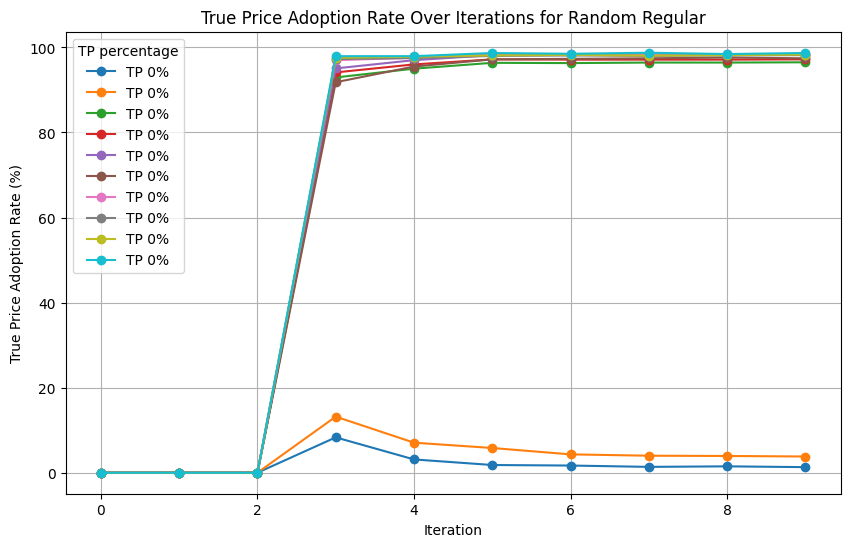

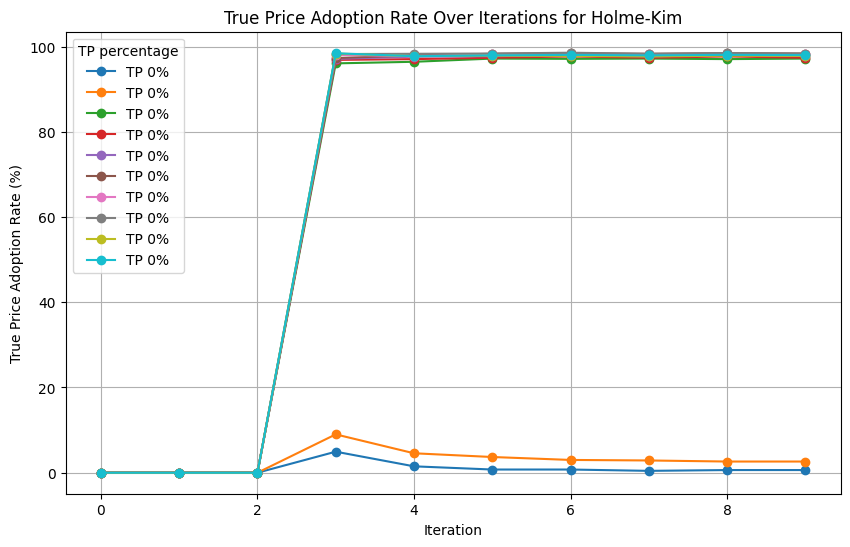

In [8]:

# Plot results
for network_name, config in network_configurations.items():
    plt.figure(figsize=(10, 6))
    
    # Plot individual simulations with transparency for each configuration
    for config_name, sim_data_list in all_simulation_data.items():
        if network_name in config_name:
            tp_percentage = float(config_name.split('_TP_')[-1].replace('%', '')) / 100
            tp_percentage_label = int(tp_percentage * 100)
            sim_data = sim_data_list[0]  # Assuming we have only one simulation per configuration
            plt.plot(sim_data['Adoption Rates'], marker='o', label=f'TP {tp_percentage_label}%')
    
    plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
    plt.xlabel('Iteration')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.grid(True)
    plt.legend(title='TP percentage')
    plt.show()


### Varying alpha values

Running simulations for Watts-Strogatz network with alpha=0.1...


Simulation Progress: 100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Running simulations for Watts-Strogatz network with alpha=1.0...


Simulation Progress: 100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


Running simulations for Watts-Strogatz network with alpha=2.0...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  9.86it/s]


Running simulations for Watts-Strogatz network with alpha=5.0...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  9.92it/s]


Running simulations for Watts-Strogatz network with alpha=10.0...


Simulation Progress: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


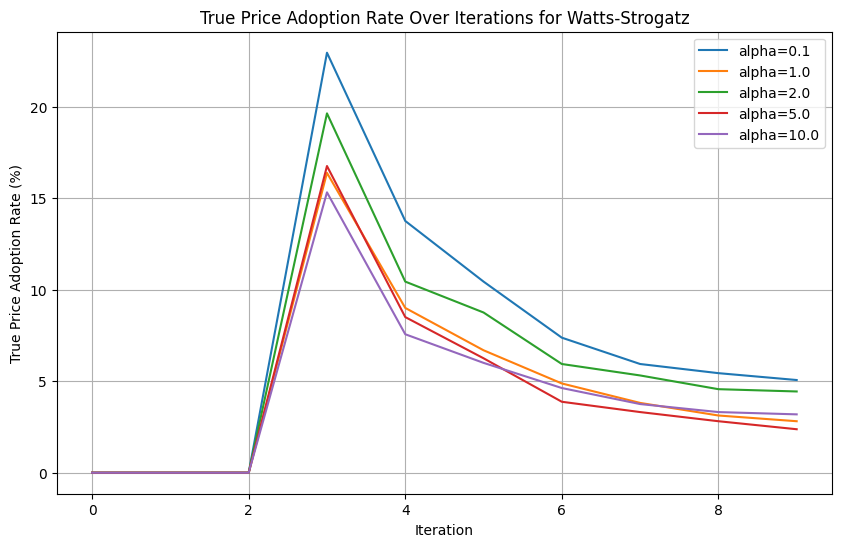

Running simulations for Barabasi-Albert network with alpha=0.1...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


Running simulations for Barabasi-Albert network with alpha=1.0...


Simulation Progress: 100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


Running simulations for Barabasi-Albert network with alpha=2.0...


Simulation Progress: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


Running simulations for Barabasi-Albert network with alpha=5.0...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Running simulations for Barabasi-Albert network with alpha=10.0...


Simulation Progress: 100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


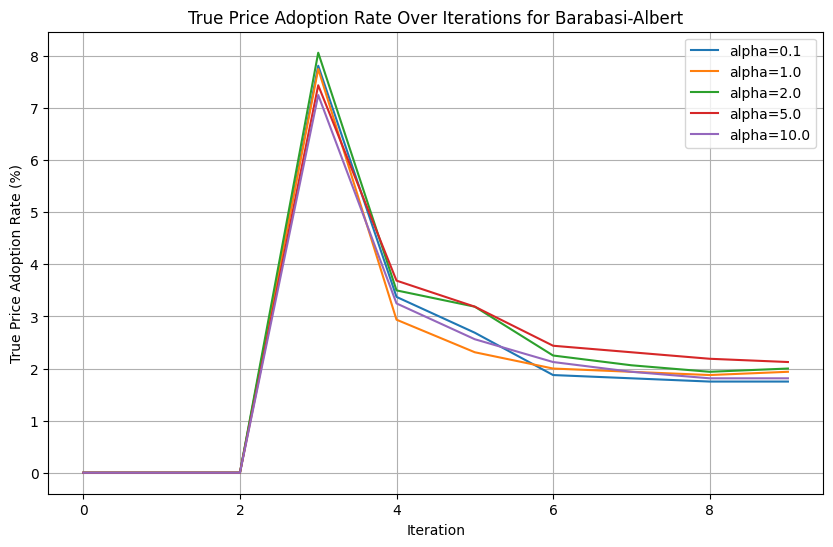

Running simulations for Random Regular network with alpha=0.1...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Running simulations for Random Regular network with alpha=1.0...


Simulation Progress: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


Running simulations for Random Regular network with alpha=2.0...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


Running simulations for Random Regular network with alpha=5.0...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  8.38it/s]


Running simulations for Random Regular network with alpha=10.0...


Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


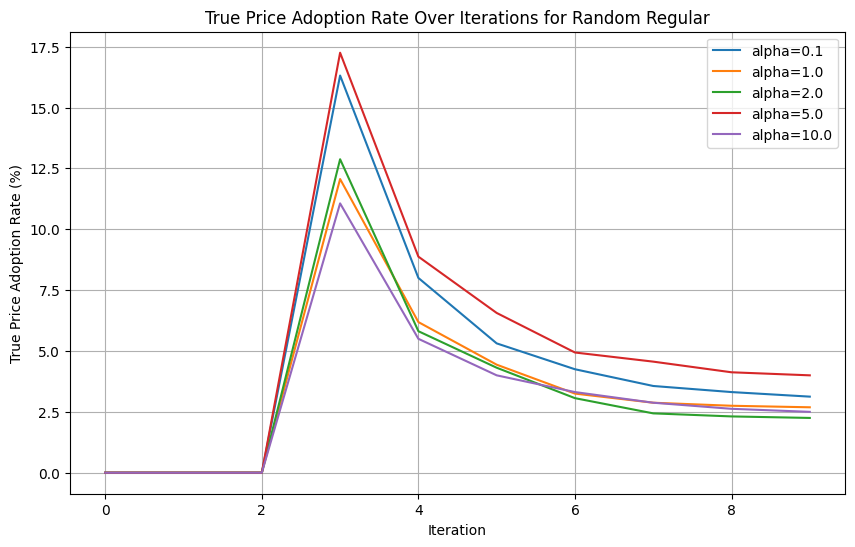

Running simulations for Holme-Kim network with alpha=0.1...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Running simulations for Holme-Kim network with alpha=1.0...


Simulation Progress: 100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


Running simulations for Holme-Kim network with alpha=2.0...


Simulation Progress: 100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Running simulations for Holme-Kim network with alpha=5.0...


Simulation Progress: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Running simulations for Holme-Kim network with alpha=10.0...


Simulation Progress: 100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


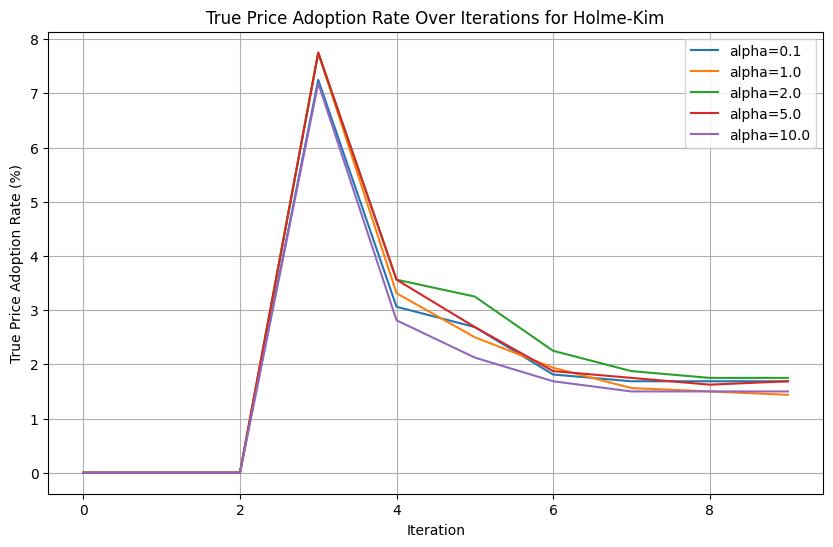

Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.10s/it]


Decision Mode Counts for Watts-Strogatz network:
      Repeat  Imitate  Deliberate  Social_Compare
Step                                             
1        126      977         163             334
2        326      936          49             289
3        387      987          16             210
4        689      585         191             135
5        875      599          44              82
6        543      977          16              64
7        411     1129          14              46
8        342     1201          14              43
9        312     1237          12              39
10       309     1244          11              36


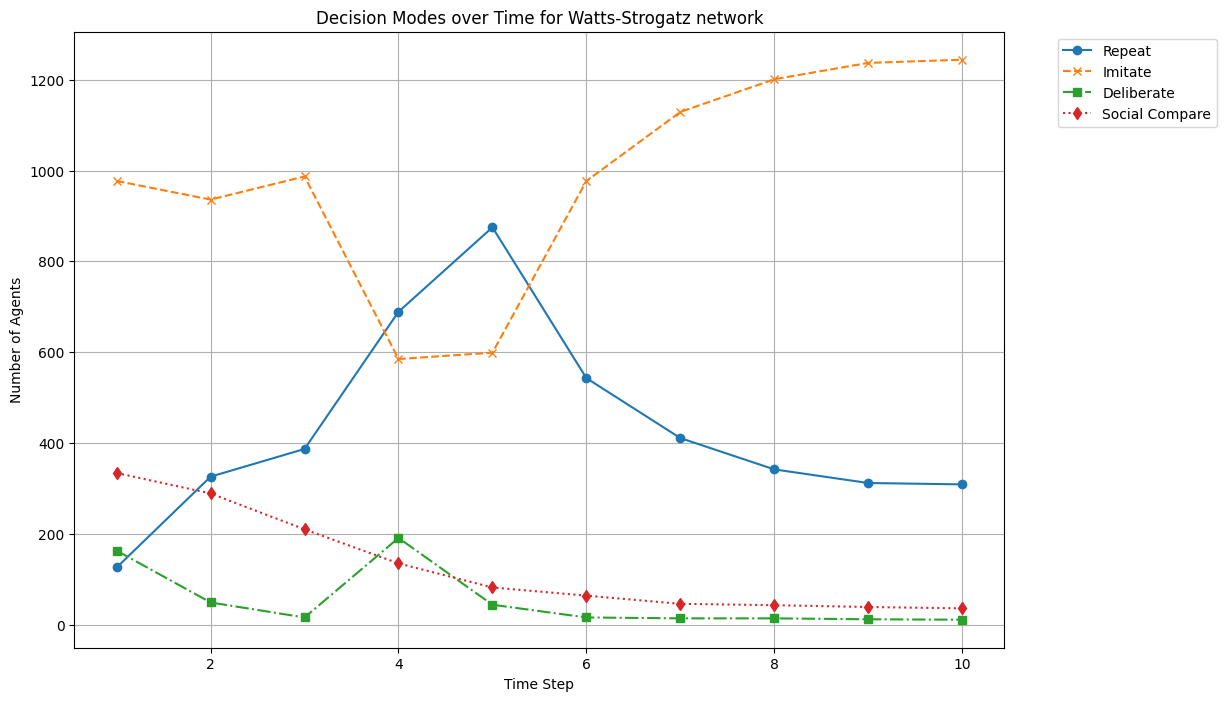

Simulation Progress: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Decision Mode Counts for Barabasi-Albert network:
      Repeat  Imitate  Deliberate  Social_Compare
Step                                             
1        126      977         163             334
2        343      980          38             239
3        434     1096           7              63
4        771      694         106              29
5        760      786          24              30
6        461     1093          14              32
7        391     1165          14              30
8        345     1216          14              25
9        325     1237          14              24
10       325     1239          14              22


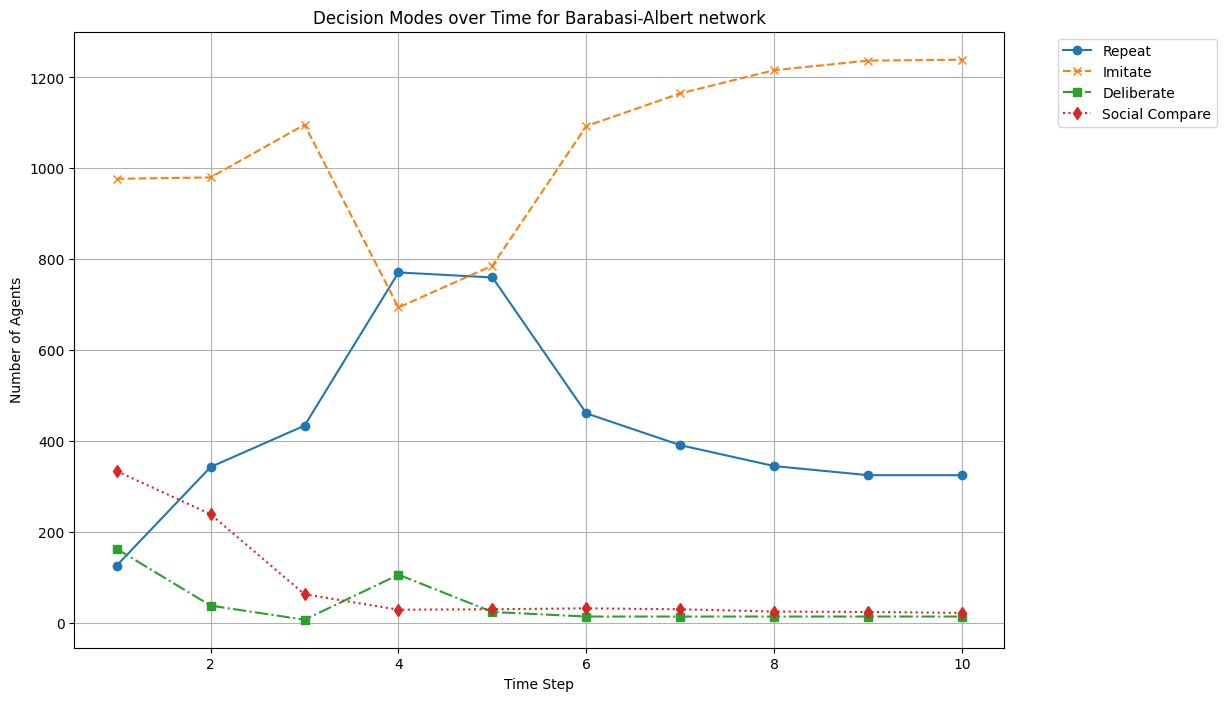

Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


Decision Mode Counts for Random Regular network:
      Repeat  Imitate  Deliberate  Social_Compare
Step                                             
1        126      977         163             334
2        328      940          40             292
3        399     1004          12             185
4        653      753         120              74
5        780      752          26              42
6        493     1063          16              28
7        403     1160          12              25
8        363     1201          12              24
9        364     1201          12              23
10       357     1205          12              26


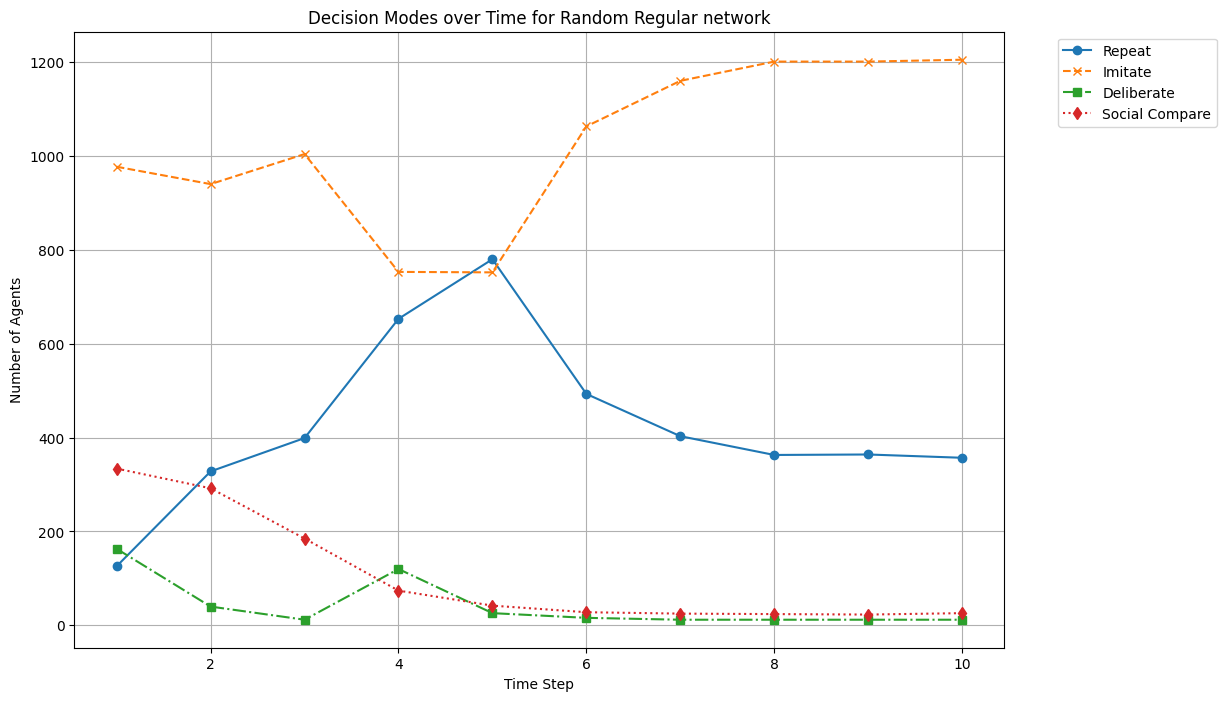

Simulation Progress: 100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


Decision Mode Counts for Holme-Kim network:
      Repeat  Imitate  Deliberate  Social_Compare
Step                                             
1        126      977         163             334
2        340      939          30             291
3        437     1076           8              79
4        767      700         102              31
5        784      764          22              30
6        448     1111          11              30
7        393     1170          11              26
8        344     1222          10              24
9        331     1234          10              25
10       327     1240          10              23


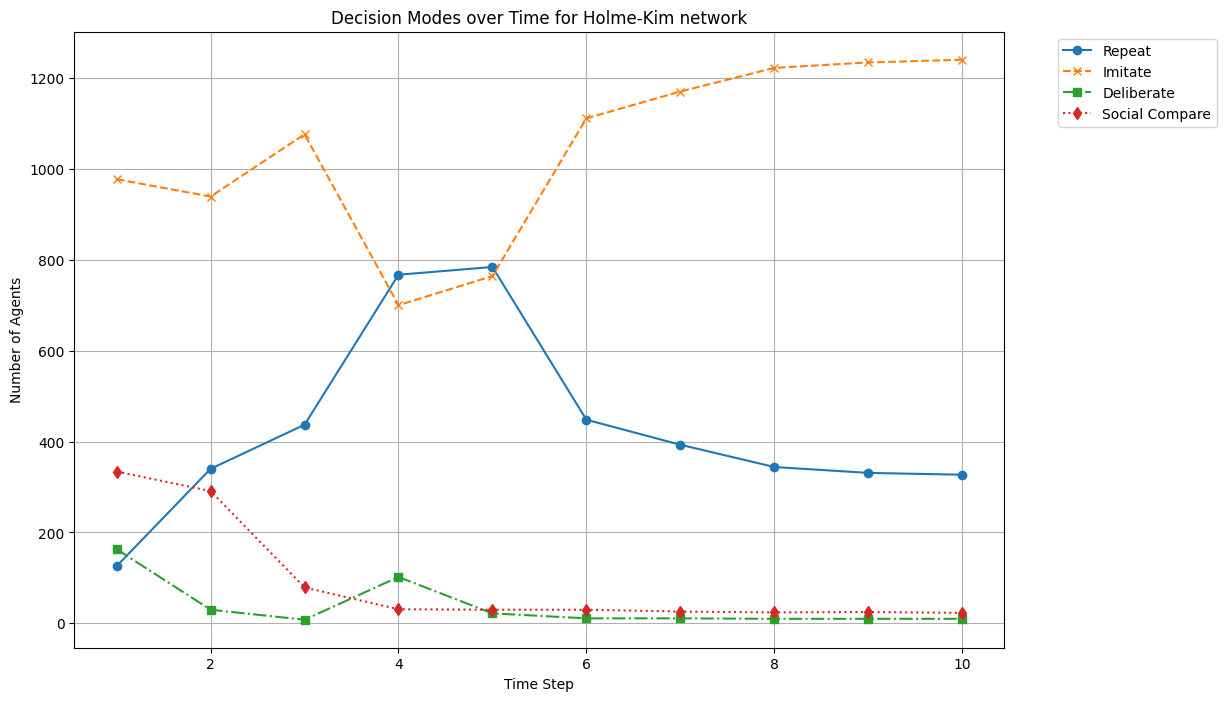

In [6]:

# Base Configuration
base_config = {
    'TP_percentage': 0.49,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 1.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'weight_social',  # Attribute to use for homophily-based rewiring
    'rewiring_probability': 0.1  # Probability of rewiring edges during the simulation
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.1
    }
})

# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

# Store all configurations in a dictionary
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

def run_simulation(model, num_steps):
    # List to store True Price Adoption Rates
    adoption_rates = []

    # Run the model for a specified number of steps with tqdm for progress tracking
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Calculate and append the current adoption rate to the list
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    # Retrieve collected data from the model's DataCollector
    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    # Append the adoption rates to the DataFrame
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations, alpha_values):
    for config_name, config in configurations.items():
        plt.figure(figsize=(10, 6))
        
        for alpha in alpha_values:
            config['alpha'] = alpha
            print(f"Running simulations for {config_name} network with alpha={alpha}...")

            # Store all simulation data for the current configuration
            all_simulation_data = []
            
            # Loop over the number of simulations
            for simulation in range(num_simulations):
                # Initialize the model with the current configuration
                model = ConsumatModel(config)
                
                # Run the model and collect data
                model_data, agent_data = run_simulation(model, num_steps)
                all_simulation_data.append(model_data)

            # Aggregate results for plotting
            aggregated_data = pd.concat(all_simulation_data).groupby(level=0).mean()

            # Plotting True Price Adoption Rates
            plt.plot(aggregated_data['Adoption Rates'], label=f'alpha={alpha}')
        
        plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

    return



### Vary True Price percentage

In [ ]:
# Define a range of values for TP_percentage
tp_percentages = np.arange(0.4, 1, 0.1) 

# Hold the number of steps constant for each simulation
num_steps = 10


base_config = {
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.5,  # Probability for node vs. edge addition
        'rewiring_probability': 0.1  # Example value
    },
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'homophily_attribute': 'weight_social',  # Attribute to use for homophily
    'tolerance': 0.5,  # Tolerance range for homophily
    'alpha': 1.0,  # Homophily sensitivity parameter
    'b': 0.5,  # Homophily threshold parameter
    'seed': 42  # Seed for reproducibility
}

# Store all configurations in a dictionary
network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Function to run simulations for each TP_percentage
def run_simulation_for_tp_percentage(config, tp_percentages, num_steps):
    adoption_rates_by_tp_percentage = []

    for tp_percentage in tqdm(tp_percentages, desc='TP Percentage Progress'):
        # Update the config with the current TP_percentage
        config['TP_percentage'] = tp_percentage
        
        # Run the simulation
        model = ConsumatModel(config)
        model_data, _ = run_simulation(model, num_steps)
        
        # Extract the adoption rates from the DataFrame
        adoption_rates = model_data['Adoption Rates'].values
        
        # Store the adoption rates for this TP_percentage
        adoption_rates_by_tp_percentage.append(adoption_rates)
    
    return adoption_rates_by_tp_percentage

# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    print(f"Running simulations for {network_name} network...")
    config = base_config.copy()
    config.update(network_config)
    adoption_rates_by_tp_percentage = run_simulation_for_tp_percentage(config, tp_percentages, num_steps)
    all_network_results[network_name] = adoption_rates_by_tp_percentage

# Plot the results for each network
for network_name, adoption_rates_by_tp_percentage in all_network_results.items():
    plt.figure(figsize=(10, 6))
    for i, tp_percentage in enumerate(tp_percentages):
        plt.plot(range(1, num_steps + 1), adoption_rates_by_tp_percentage[i], label=f'TP_percentage = {tp_percentage:.1f}', marker='o')
    plt.title(f'True Price Percentage Impact on Adoption Rate - {network_name}')
    plt.xlabel('Time Step')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

Running simulations for Watts-Strogatz network...


TP Percentage Progress:   0%|          | 0/19 [00:12<?, ?it/s]


KeyboardInterrupt: 

Running simulations for Homophily_Assortative_Network network...


Homophily Attribute Progress: 100%|██████████| 5/5 [04:44<00:00, 56.89s/it]


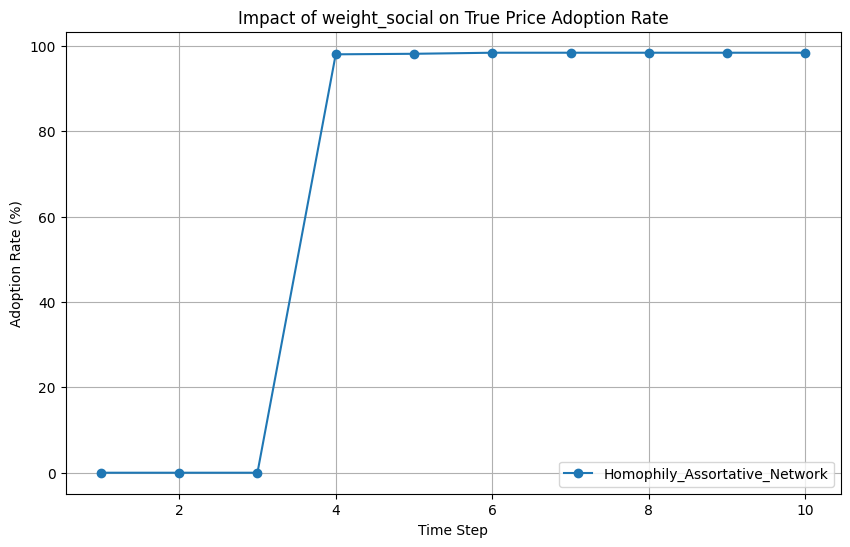

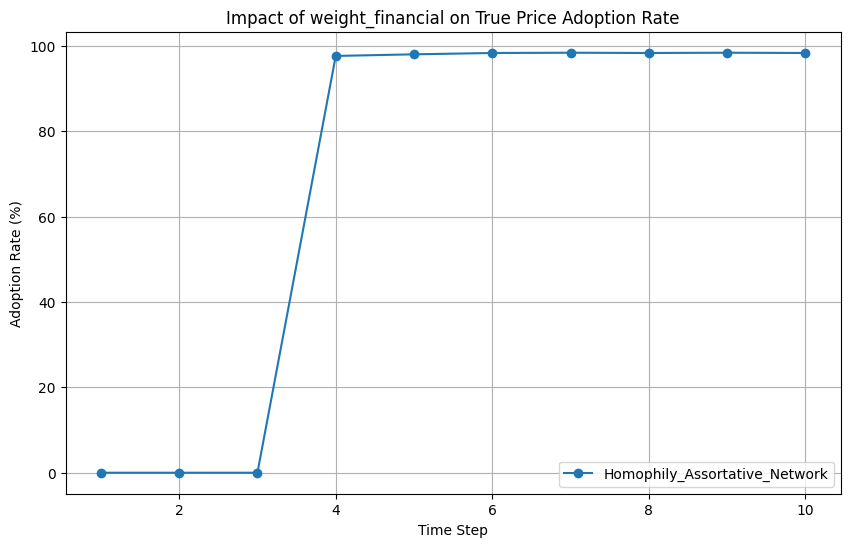

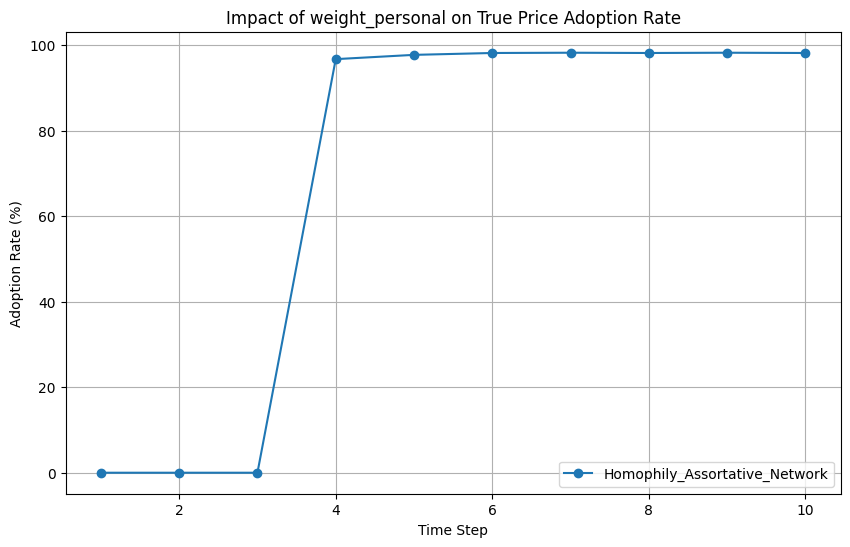

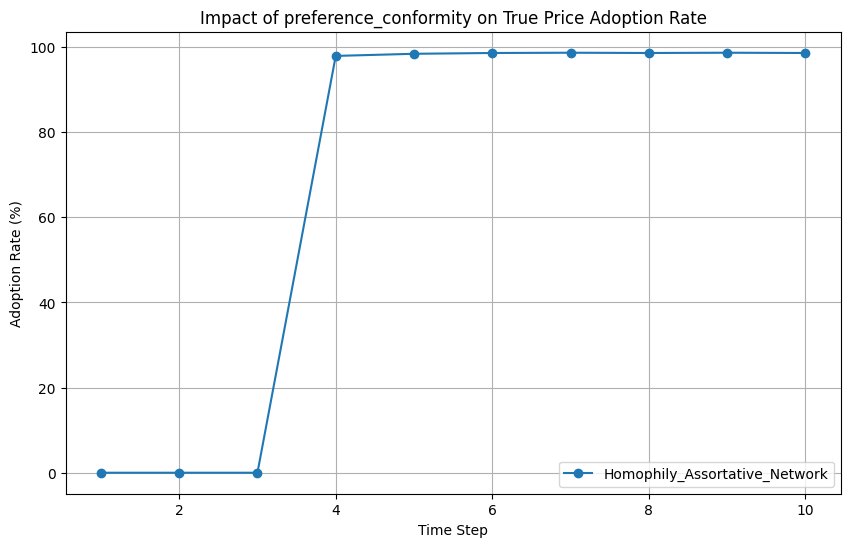

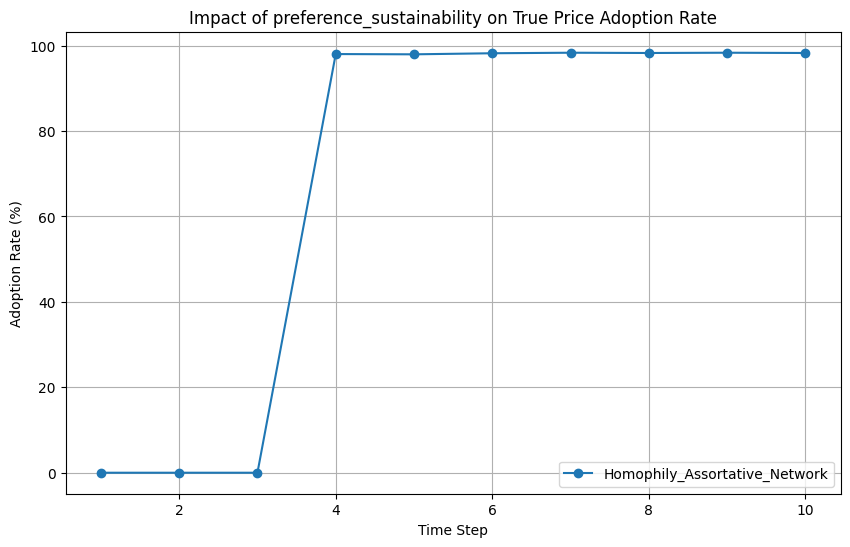

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx

config = {
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.5,  # Probability for node vs. edge addition
        'rewiring_probability': 0.1  # Example value
    },
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'homophily_attribute': 'weight_social',  # Attribute to use for homophily
    'tolerance': 0.5,  # Tolerance range for homophily
    'alpha': 1.0,  # Homophily sensitivity parameter
    'b': 0.5,  # Homophily threshold parameter
    'seed': 42  # Seed for reproducibility
}

# Define the network configurations for simulation
network_configs = {
    'Homophily_Assortative_Network': config
}

# Define a range of homophily attributes
homophily_attributes = ['weight_social', 'weight_financial', 'weight_personal', 'preference_conformity', 'preference_sustainability']

def run_simulation_for_homophily_attribute(config, homophily_attributes, num_steps):
    adoption_rates_by_attribute = []

    for attribute in tqdm(homophily_attributes, desc='Homophily Attribute Progress'):
        # Update the config with the current homophily attribute
        config['homophily_attribute'] = attribute
        
        # Run the simulation
        model = ConsumatModel(config)
        model_data, _ = run_simulation(model, num_steps)
        
        # Extract the adoption rates from the DataFrame
        adoption_rates = model_data['Adoption Rates'].values
        
        # Store the adoption rates for this homophily attribute
        adoption_rates_by_attribute.append(adoption_rates)
    
    return adoption_rates_by_attribute


# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    print(f"Running simulations for {network_name} network...")
    config = network_config.copy()
    adoption_rates_by_attribute = run_simulation_for_homophily_attribute(config, homophily_attributes, num_steps)
    all_network_results[network_name] = adoption_rates_by_attribute

# Plot the results for each homophily attribute
for attribute_idx, attribute in enumerate(homophily_attributes):
    plt.figure(figsize=(10, 6))
    for network_name, adoption_rates_by_attribute in all_network_results.items():
        plt.plot(range(1, num_steps + 1), adoption_rates_by_attribute[attribute_idx], marker='o', label=f'{network_name}')
    plt.title(f'Impact of {attribute} on True Price Adoption Rate')
    plt.xlabel('Time Step')
    plt.ylabel('Adoption Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


Homophily Attribute Progress: 100%|██████████| 5/5 [1:02:53<00:00, 754.72s/it]


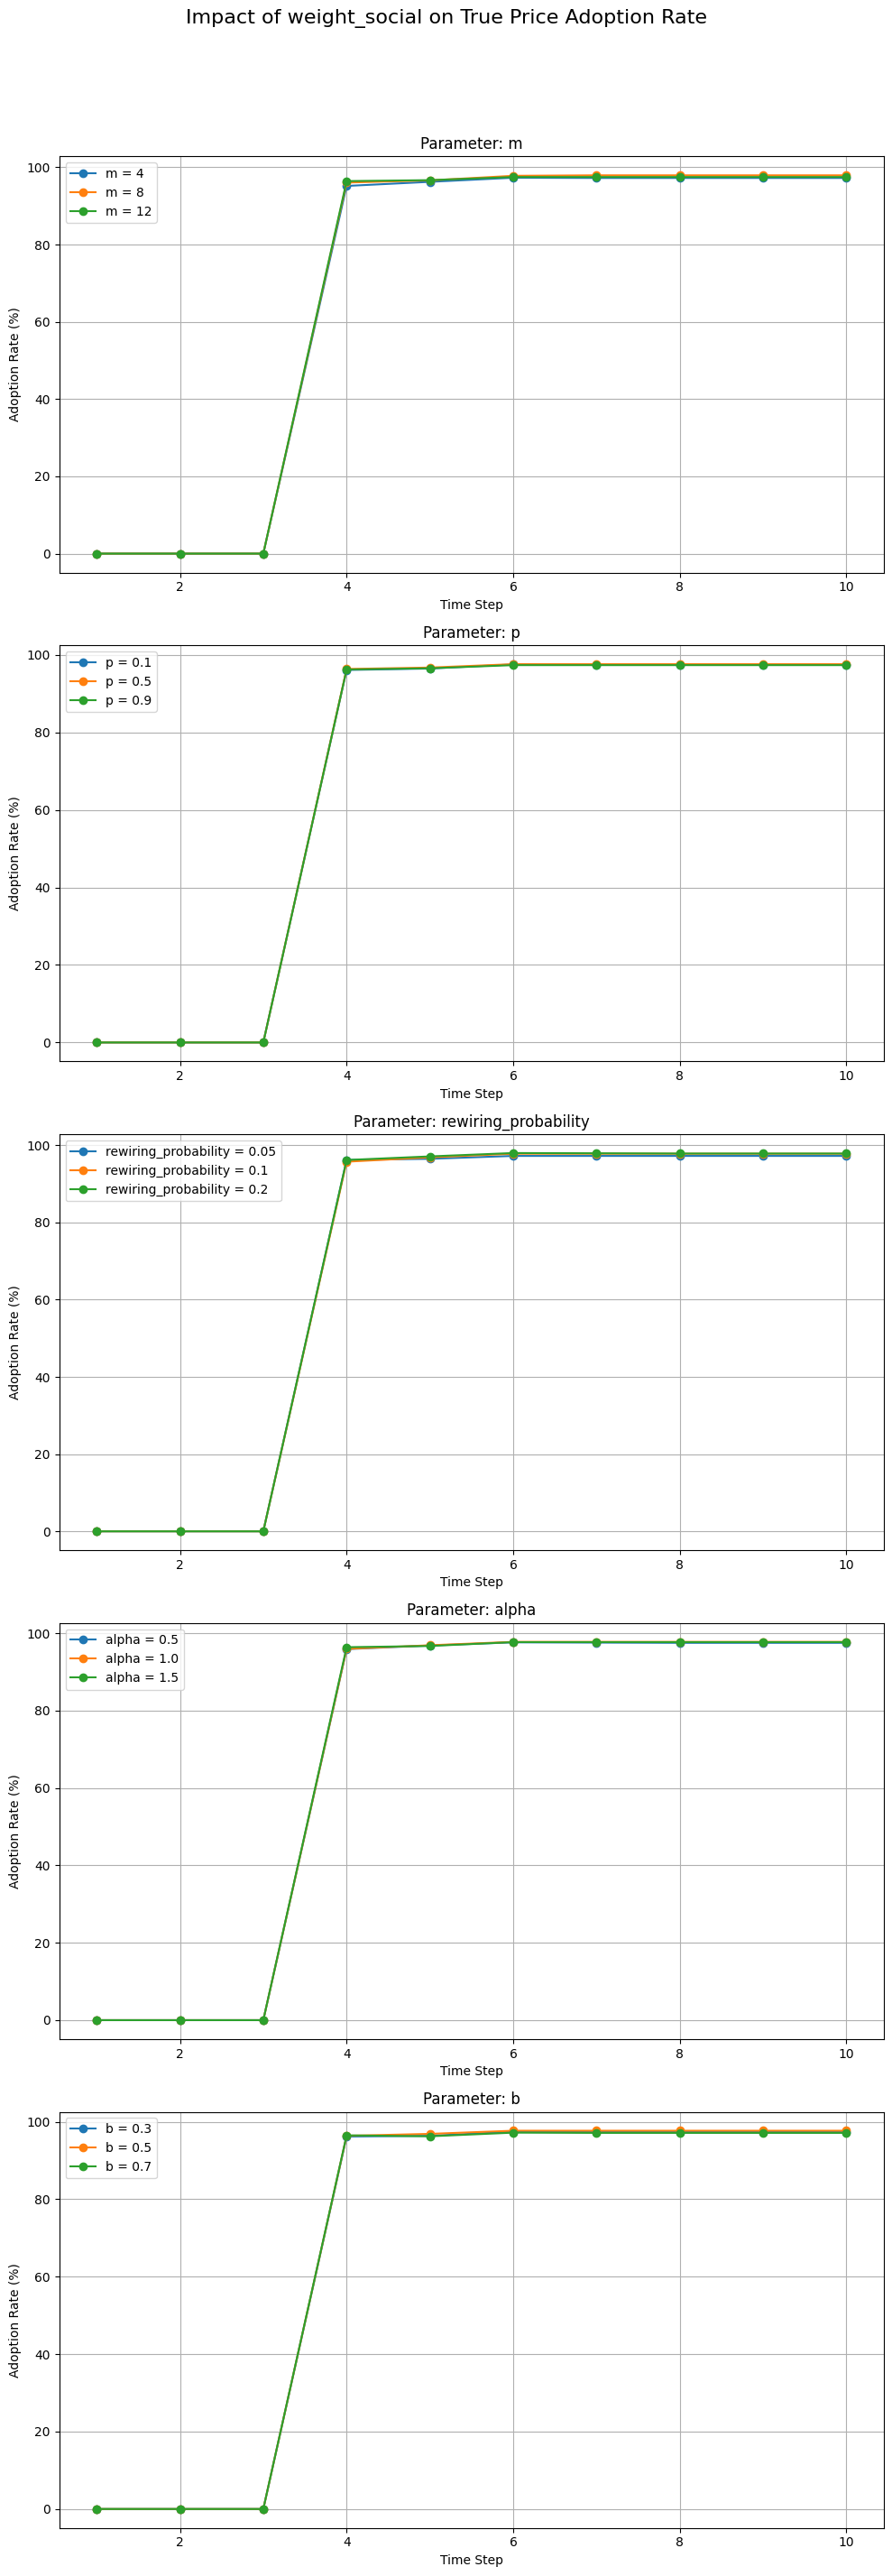

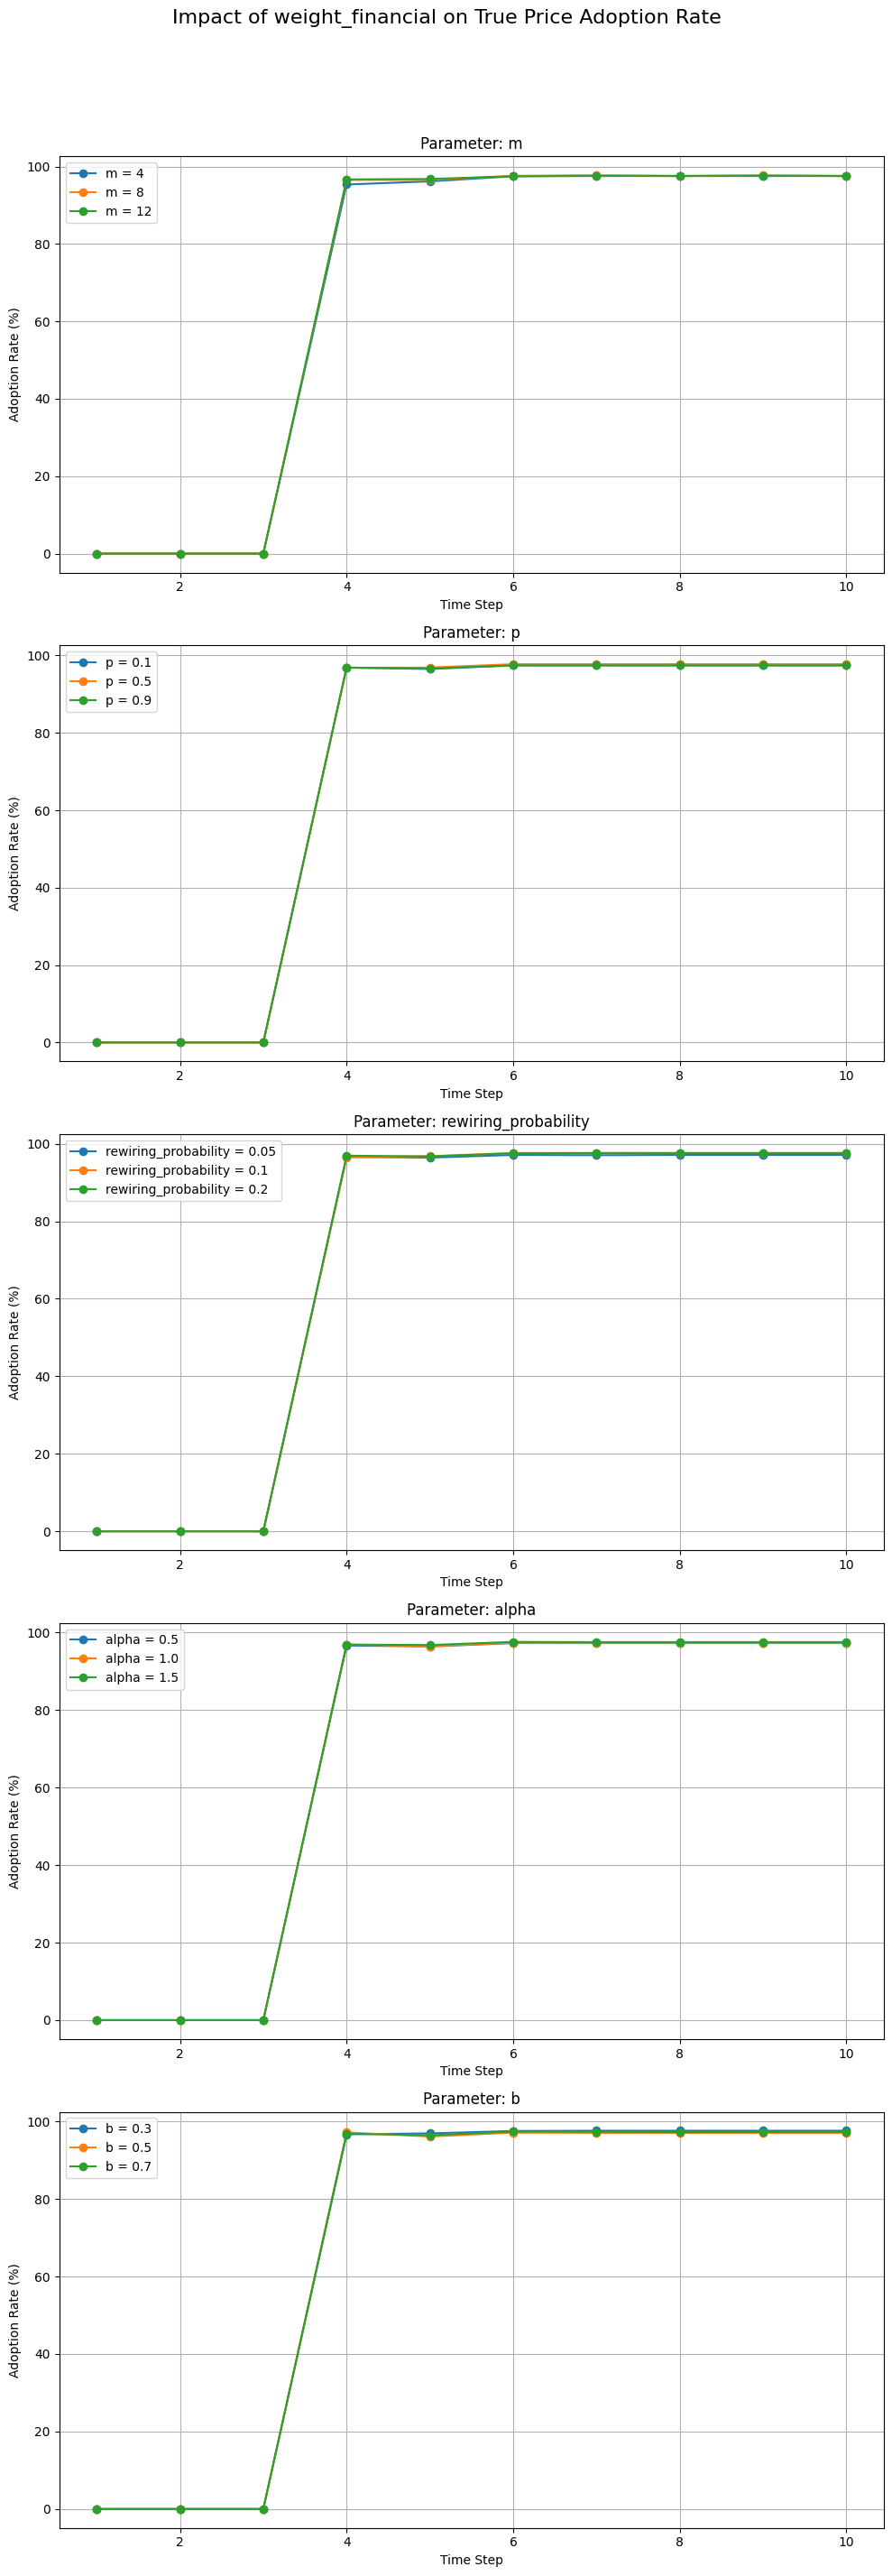

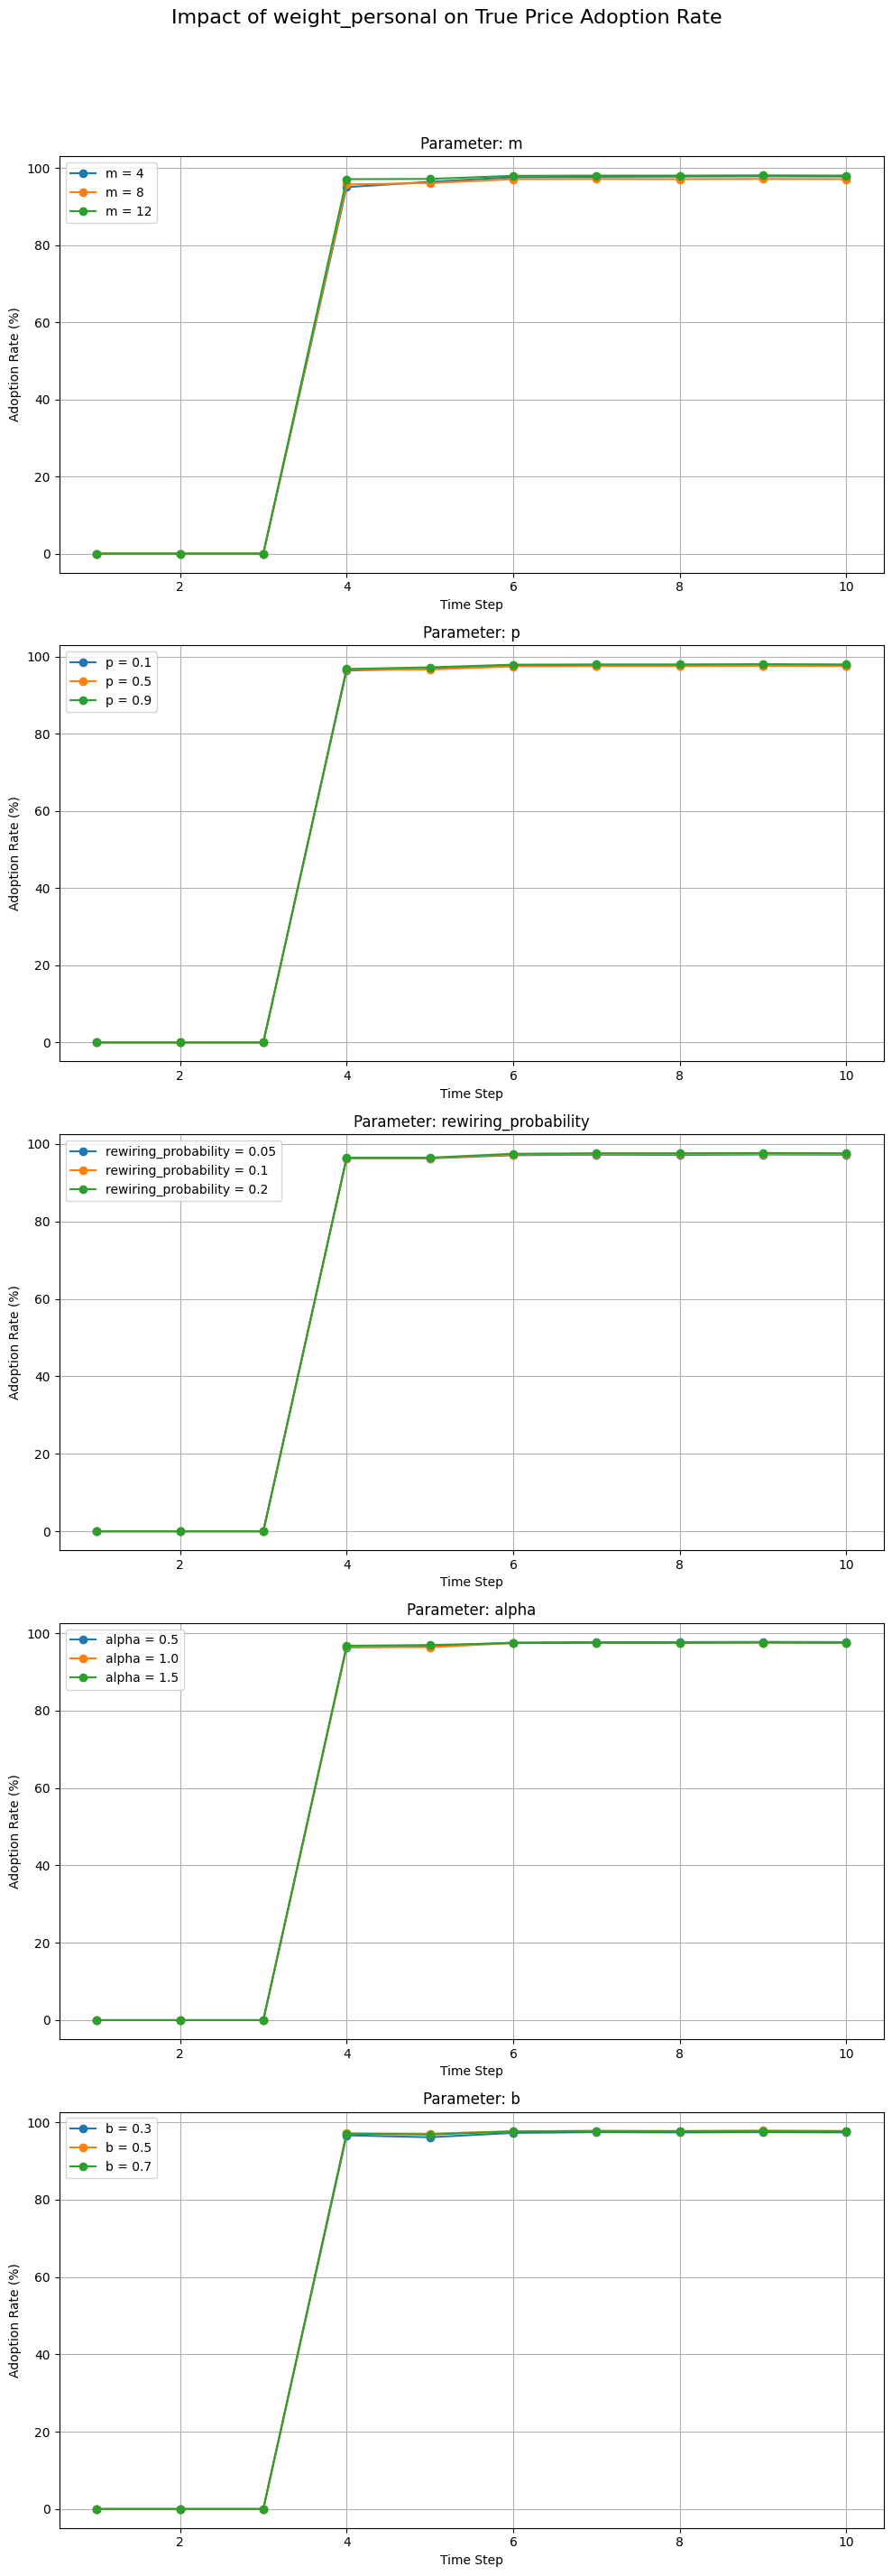

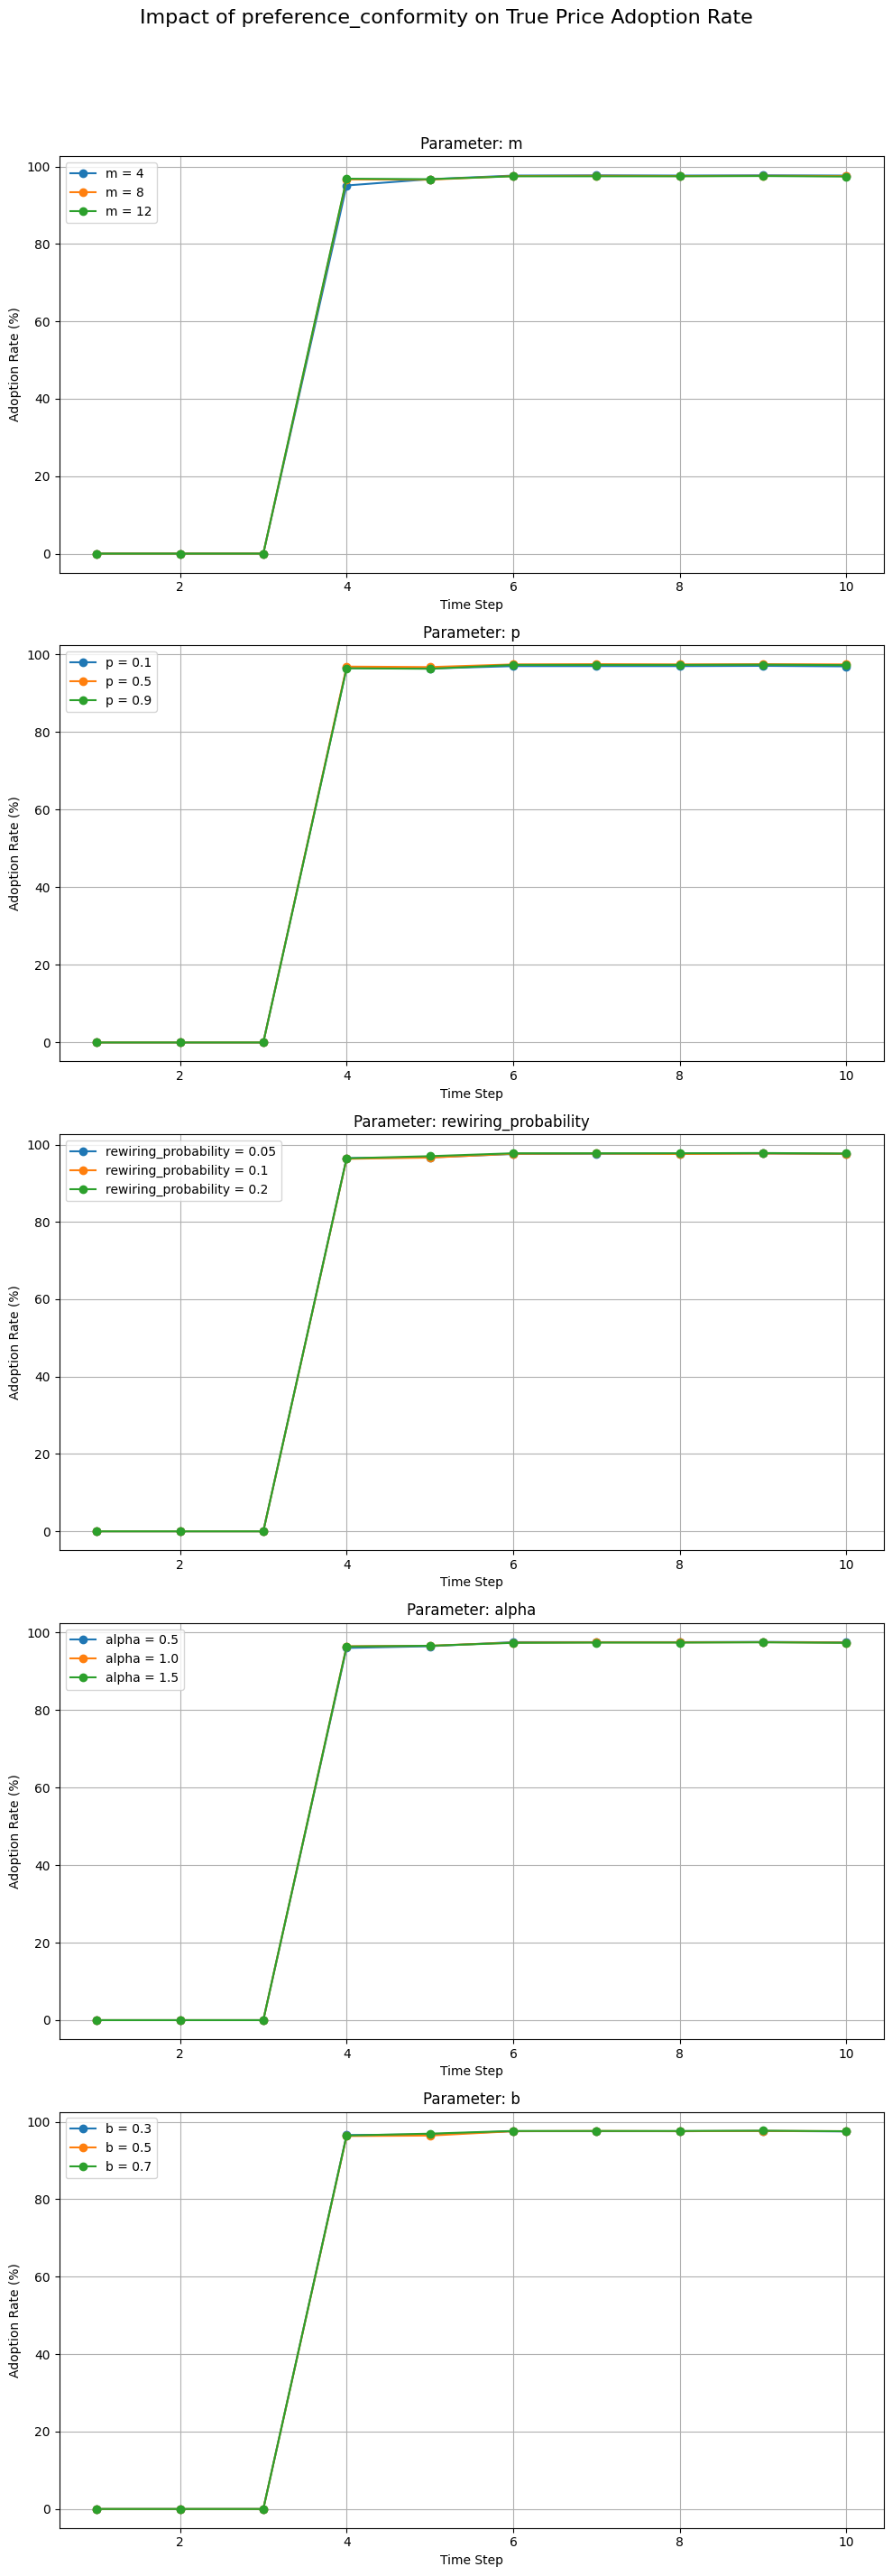

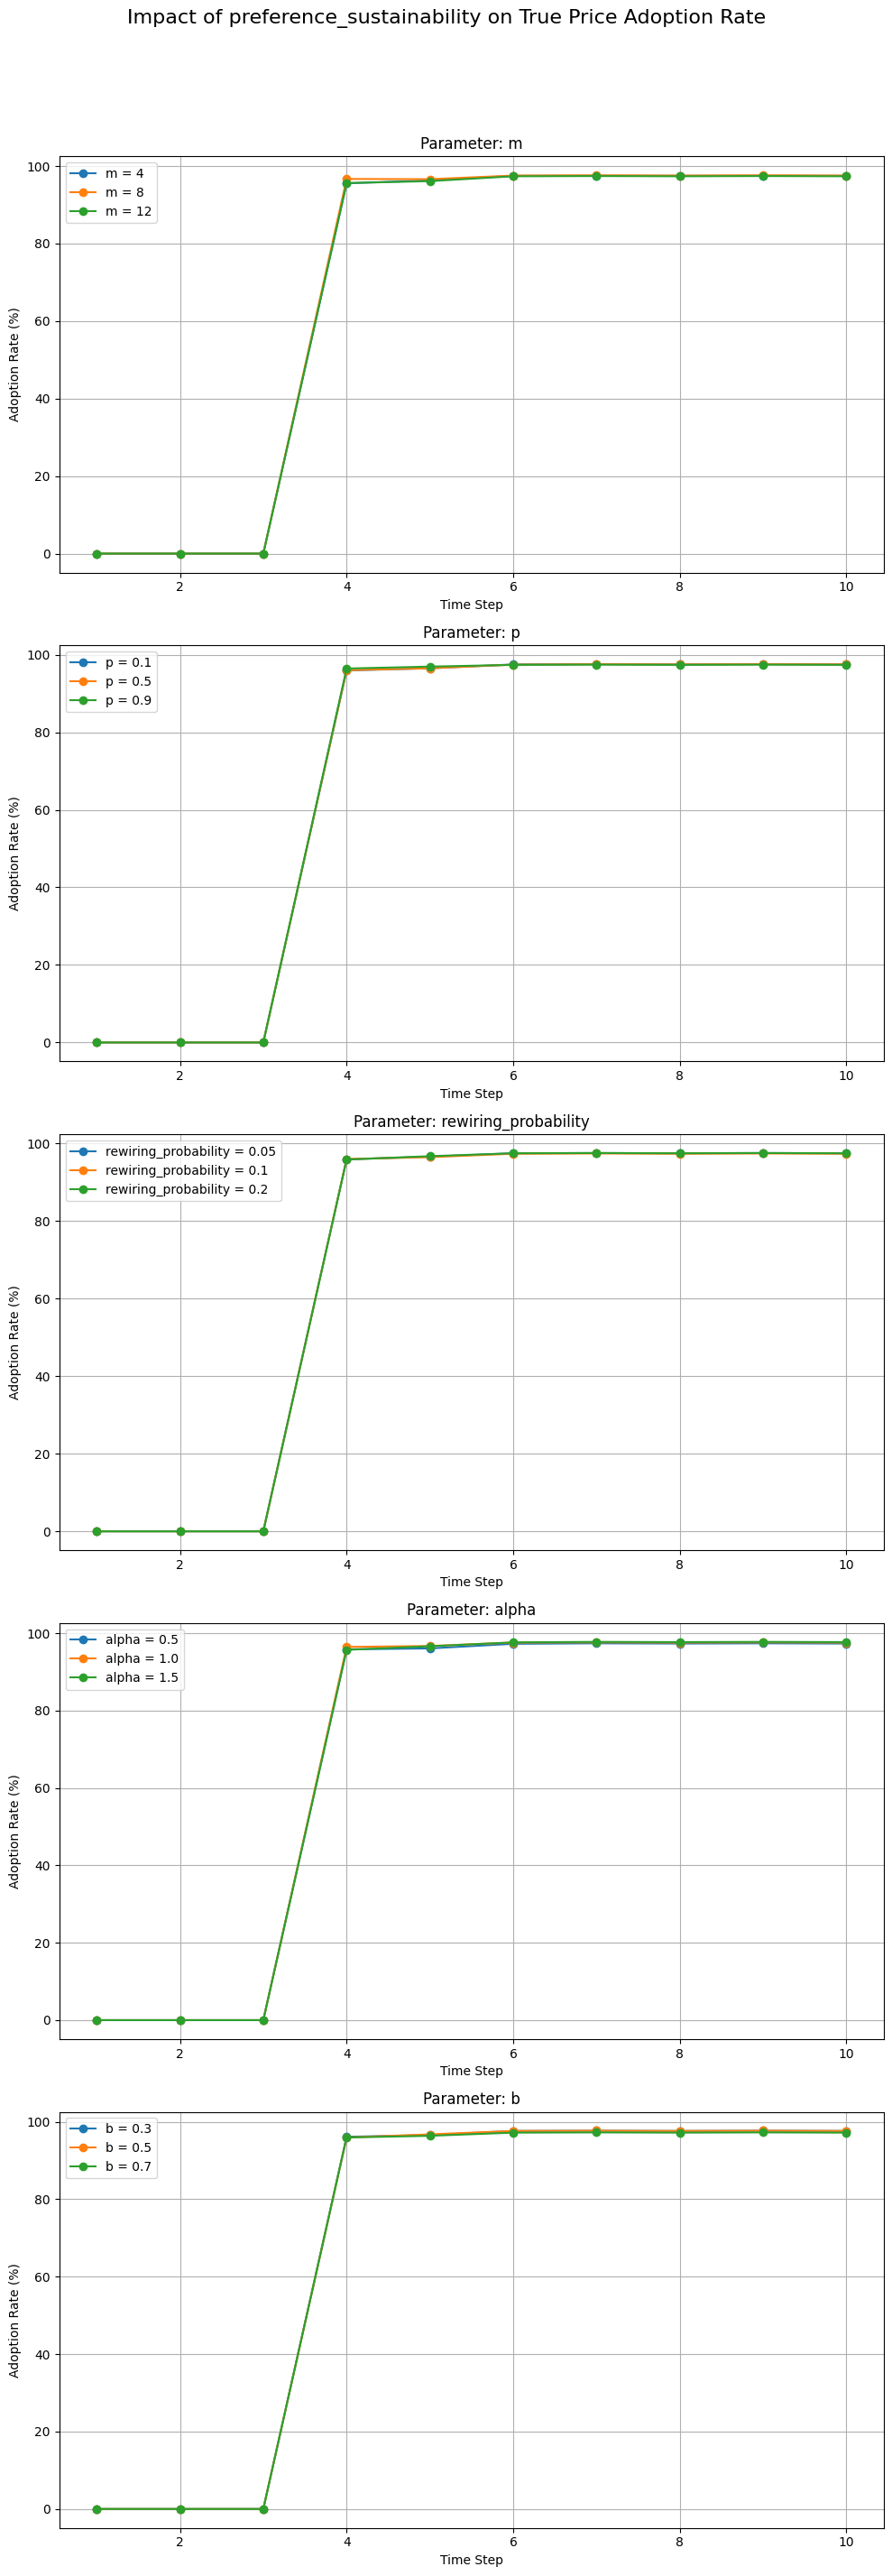

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx

# Define the base model configuration
config = {
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.5,  # Probability for node vs. edge addition
        'rewiring_probability': 0.1  # Example value
    },
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'homophily_attribute': 'weight_social',  # Attribute to use for homophily
    'tolerance': 0.5,  # Tolerance range for homophily
    'alpha': 1.0,  # Homophily sensitivity parameter
    'b': 0.5,  # Homophily threshold parameter
    'seed': 42  # Seed for reproducibility
}

# Define the network configurations for simulation
network_configs = {
    'Homophily_Assortative_Network': config
}

# Define a range of homophily attributes
homophily_attributes = ['weight_social', 'weight_financial', 'weight_personal', 'preference_conformity', 'preference_sustainability']

# Define ranges for network parameters
network_param_ranges = {
    'm': [4, 8, 12],
    'p': [0.1, 0.5, 0.9],
    'rewiring_probability': [0.05, 0.1, 0.2],
    'alpha': [1, 4, 8],
    'b': [0.3, 0.5, 0.7]
}

# Number of steps to run the simulation
num_steps = 10

def run_simulation(model, num_steps):
    # List to store True Price Adoption Rates
    adoption_rates = []

    # Run the model for a specified number of steps with tqdm for progress tracking
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Calculate and append the current adoption rate to the list
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    # Retrieve collected data from the model's DataCollector
    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    # Append the adoption rates to the DataFrame
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_simulation_for_homophily_and_network_params(config, homophily_attributes, network_param_ranges, num_steps):
    results = {}

    for attribute in tqdm(homophily_attributes, desc='Homophily Attribute Progress'):
        config['homophily_attribute'] = attribute
        results[attribute] = {}

        for param, values in network_param_ranges.items():
            results[attribute][param] = {}
            for value in values:
                config['network_params'][param] = value

                # Run the simulation
                model = ConsumatModel(config)
                model_data, _ = run_simulation(model, num_steps)

                # Extract the adoption rates from the DataFrame
                adoption_rates = model_data['Adoption Rates'].values

                # Store the adoption rates for this network parameter value
                results[attribute][param][value] = adoption_rates

    return results

# Run simulations and collect results for all combinations of homophily attributes and network parameters
all_results = run_simulation_for_homophily_and_network_params(config, homophily_attributes, network_param_ranges, num_steps)

# Plot the results for each homophily attribute and network parameter using subfigures
for attribute in homophily_attributes:
    fig, axs = plt.subplots(len(network_param_ranges), 1, figsize=(10, 6 * len(network_param_ranges)))
    fig.suptitle(f'Impact of {attribute} on True Price Adoption Rate', fontsize=16)

    for idx, param in enumerate(network_param_ranges.keys()):
        for value in network_param_ranges[param]:
            axs[idx].plot(range(1, num_steps + 1), all_results[attribute][param][value], marker='o', label=f'{param} = {value}')
        axs[idx].set_title(f'Parameter: {param}')
        axs[idx].set_xlabel('Time Step')
        axs[idx].set_ylabel('Adoption Rate (%)')
        axs[idx].legend()
        axs[idx].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Visualise smaller network

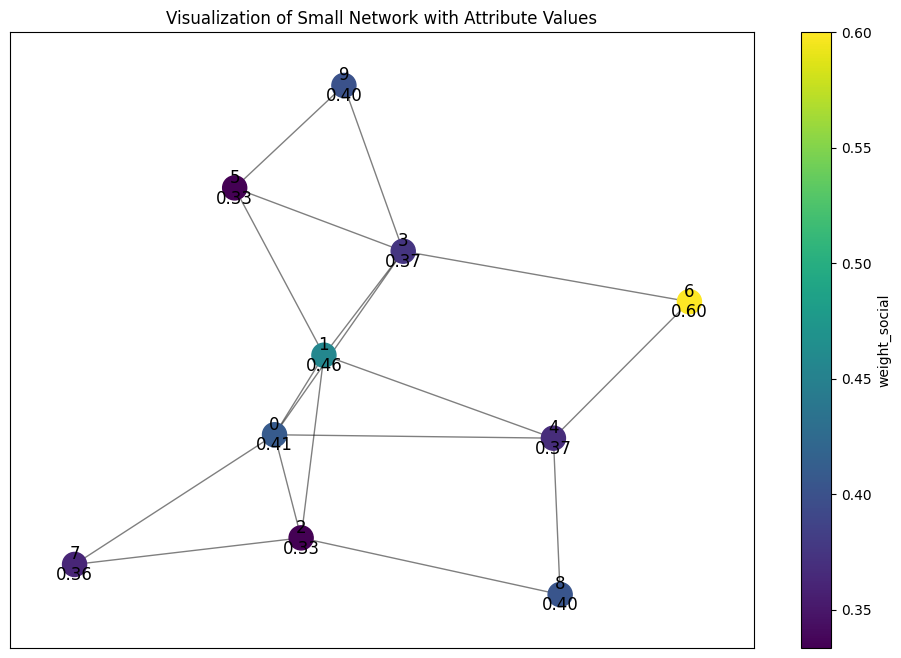

In [33]:
small_network_config = {
    'network_params': {
        'n': 10,  # Smaller network with 10 nodes
        'm': 2,
        'p': 0.2,  # Probability for node vs. edge addition
        'rewiring_probability': 0.1  # Example value
    },
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'homophily_attribute': 'weight_social',  # Attribute to use for homophily
    'tolerance': 0.8,  # Tolerance range for homophily
    'alpha': 1.0,  # Homophily sensitivity parameter
    'b': 0.5,  # Homophily threshold parameter
    'seed': 42  # Seed for reproducibility
}

# Define the small network configuration for simulation
small_network_configs = {
    'Homophily_Assortative_Network': small_network_config
}
import networkx as nx
import matplotlib.pyplot as plt

# Create a smaller version of your model for visualization
small_model = ConsumatModel(small_network_config)

# Extract the network
G = small_model.G

# Generate positions for visualization
pos = nx.spring_layout(G)

# Draw the network
plt.figure(figsize=(12, 8))

# Draw nodes with color based on their attribute value (e.g., weight_social)
node_colors = [getattr(agent, small_network_config['homophily_attribute']) for agent in small_model.schedule.agents]
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=300)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels for nodes to show their unique IDs
labels = {agent.unique_id: f"{agent.unique_id}\n{getattr(agent, small_network_config['homophily_attribute']):.2f}" for agent in small_model.schedule.agents}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

# Add a color bar
cbar = plt.colorbar(nodes)
cbar.set_label(small_network_config['homophily_attribute'])

plt.title("Visualization of Small Network with Attribute Values")
plt.show()




## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

In [11]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 10.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'budget'  # Attribute to use for homophily-based rewiring
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.1
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'k', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1], [0, 10], [0, 1]]
    },
    'Barabasi-Albert': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'm', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Random Regular': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'd', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Holme-Kim': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20], [2, 10], [0, 1],[0, 10], [0, 1]]
    }
}

# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

# Function to collect data from the model
def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['alpha'] = params[-4]
    config['beta'] = params[-3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['budget']

# Run GSA for each network and each homophily attribute
for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        # Perform Sobol sensitivity analysis with confidence intervals
        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        # Save results to a JSON file
        with open(f'sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)



/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_18388/440639957.py:106: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network with budget attribute...













































































































































































































































































































































































































































































































































































































































































































































Running simulations for Watts-Strogatz with budget: 100%|██████████| 5632/5632 [32:46<00:00,  2.86it/s]


                               ST   ST_conf
TP_percentage            0.993048  0.120235
satisfaction_threshold   0.051799  0.014736
uncertainty_threshold    0.051942  0.018969
epsilon                  0.003476  0.001485
min_increase_percentage  0.002152  0.000625
max_increase_percentage  0.002861  0.001182
k                        0.009777  0.003714
p                        0.003872  0.001385
alpha                    0.002725  0.001023
beta                     0.002547  0.000845
                               S1   S1_conf
TP_percentage            0.910409  0.122854
satisfaction_threshold  -0.005886  0.037716
uncertainty_threshold   -0.019182  0.035860
epsilon                 -0.000340  0.009886
min_increase_percentage -0.006380  0.008674
max_increase_percentage  0.007499  0.008478
k                       -0.001630  0.018914
p                       -0.004464  0.010166
alpha                   -0.001295  0.009282
beta                     0.002973  0.009442
                                




































































































































































































































































































































































































































































































































































































































































Running simulations for Barabasi-Albert with budget: 100%|██████████| 5120/5120 [6:47:06<00:00,  4.77s/it]


                               ST   ST_conf
TP_percentage            0.890258  0.136110
satisfaction_threshold   0.278317  0.091717
uncertainty_threshold    0.403310  0.099827
epsilon                  0.197732  0.087856
min_increase_percentage  0.124315  0.072187
max_increase_percentage  0.151822  0.072698
m                        0.148412  0.066337
alpha                    0.147367  0.073866
beta                     0.159306  0.078041
                               S1   S1_conf
TP_percentage            0.582322  0.134300
satisfaction_threshold   0.022689  0.077289
uncertainty_threshold    0.123630  0.093943
epsilon                  0.050684  0.066919
min_increase_percentage  0.008618  0.053871
max_increase_percentage  0.018462  0.067634
m                       -0.018959  0.058236
alpha                    0.011362  0.060550
beta                    -0.013203  0.062476
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)          















































































































































































































































































































































































































































































































































































































































































Running simulations for Random Regular with budget: 100%|██████████| 5120/5120 [8:48:52<00:00,  6.20s/it]


                               ST   ST_conf
TP_percentage            0.955508  0.141695
satisfaction_threshold   0.123107  0.047242
uncertainty_threshold    0.154305  0.059260
epsilon                  0.089143  0.053811
min_increase_percentage  0.067982  0.039888
max_increase_percentage  0.072884  0.046039
d                        0.090822  0.039549
alpha                    0.047608  0.034276
beta                     0.072183  0.040227
                               S1   S1_conf
TP_percentage            0.812583  0.146658
satisfaction_threshold   0.003996  0.060150
uncertainty_threshold   -0.019104  0.069910
epsilon                  0.001993  0.051323
min_increase_percentage -0.010113  0.048466
max_increase_percentage -0.008772  0.053075
d                       -0.023675  0.059886
alpha                   -0.000626  0.036022
beta                    -0.007831  0.049251
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)          
















































































































































































































































































































































































































































































































































































































































































































































Running simulations for Holme-Kim with budget: 100%|██████████| 5632/5632 [3:34:59<00:00,  2.29s/it]


                               ST   ST_conf
TP_percentage            0.916013  0.135483
satisfaction_threshold   0.129222  0.041300
uncertainty_threshold    0.194954  0.061184
epsilon                  0.042852  0.020945
min_increase_percentage  0.022196  0.010623
max_increase_percentage  0.037315  0.018666
m                        0.053350  0.020289
p                        0.059529  0.030683
alpha                    0.032494  0.014491
beta                     0.028515  0.014178
                               S1   S1_conf
TP_percentage            0.755092  0.139494
satisfaction_threshold   0.010712  0.054053
uncertainty_threshold    0.013512  0.072827
epsilon                  0.015562  0.029051
min_increase_percentage  0.018757  0.027876
max_increase_percentage  0.027995  0.035995
m                        0.022256  0.035935
p                       -0.005326  0.037779
alpha                    0.002564  0.026436
beta                     0.016292  0.025171
                                

In [12]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_sustainability'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 10.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'preference_sustainability'  # Attribute to use for homophily-based rewiring
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.1
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'k', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1], [0, 10], [0, 1]]
    },
    'Barabasi-Albert': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'm', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Random Regular': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'd', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Holme-Kim': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20], [2, 10], [0, 1],[0, 10], [0, 1]]
    }
}

# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

# Function to collect data from the model
def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['alpha'] = params[-4]
    config['beta'] = params[-3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['preference_sustainability']

# Run GSA for each network and each homophily attribute
for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        # Perform Sobol sensitivity analysis with confidence intervals
        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        # Save results to a JSON file
        with open(f'sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)



/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_18388/1175529448.py:106: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network with preference_sustainability attribute...


KeyboardInterrupt: 

In [13]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_conformity'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 10.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'preference_conformity'  # Attribute to use for homophily-based rewiring
}



# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

network_configurations = {
    'Holme-Kim': holme_kim_config
}
network_configs = {
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Holme-Kim': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20], [2, 10], [0, 1],[0, 10], [0, 1]]
    }
}

# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

# Function to collect data from the model
def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['alpha'] = params[-4]
    config['beta'] = params[-3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['preference_conformity']

# Run GSA for each network and each homophily attribute
for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        # Perform Sobol sensitivity analysis with confidence intervals
        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        # Save results to a JSON file
        with open(f'sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)



/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_18388/1627633087.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Holme-Kim network with preference_conformity attribute...


KeyboardInterrupt: 